# Final Project Submission

* Student name: Peder Norr
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

Function that spits out the forecast and a bar graph of how much energy that will be generated in total during that forecast period

# INTRODUCTION

As the climate crisis continues to grow in severity, more and more countries and utilities are turning towards renewable energy sources as sustainable alternatives to traditional fossil fuel based sources. Chief among these are solar and wind energy. However, these two sources are known as variable renewable energies (VREs), as they are dependent on several variables like the weather. Because of this, integrating VRE sources into a power grid can be difficult due to ever changing levels of output. However, accurate generation forecasts can assuage this issue, and help utilities improve electricity allocation to more efficiently harness VREs.  This project contains analyses of renewable energy generation data in order to provide European countries and utilities a tool which would allow them to make more accurate energy generation forecasts, and thus better harness the power of renewable energy sources. 

## Business Problem



EU countries and utilities want to be able to better utilize VREs and more efficiently integrate them into their power grids. To that end, they need an accurate estimate of total VRE generation for the upcoming month of July 2021 in order to improve electricity scheduling and allocation. This project will conduct time series analyses, generate forecasts, and calculate total solar and wind energy generation, which will provide EU countries an accurate estimate of VRE generation and enable the more efficient usage of renewable energy.

# OBTAIN

The data used in these analyses come from the European Network of Transmission System Operators for Electricity (ENTSOE) [Transparency Platform](https://transparency.entsoe.eu/dashboard/show). ENTSOE represents 42 electricity transmission system operators from across Europe. It promotes closer cooperation among Europe's TSOs to achieve the EU's energy and climate policy objectives. One of its main objective centers on the integration of renewable energy sources  into the continent's power system.

Additionally, I will be using [entsoe-py](https://pypi.org/project/entsoe-py/), a python client wrapper for the ENTOSE API. This client enables the user to easily retrieve data from the API and return it in DataFrame form. It also automatically splits large requests over multiple API calls.

In order to reduce computation requirements, this project will focus on the top 5 producers of variable renewable energy in the EU: Germany, Italy, France, Spain, and the Netherlands. Due to the granularity of the data and the need for accurate forecasts, the data sets used below are time series from January 2021 to July 2021, containing ~4300 entries of the hourly production of wind and solar energy (in megawatts) in the respective country.

In [1]:
#Set to True to get new data from ENTOSE API
run_api_call = False

In [2]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd

#!pip install entsoe-py
from entsoe import EntsoePandasClient

import json

In [3]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# MODEL

## Data Modeling

For this analysis, I will be using SARIMA models to forecast VRE production for the next month in each respective country.

I begin by creating baseline models, and iterate by gridsearching to find optimal hyperparameters. I then use the best models to create the forecasts.

In [4]:
#Create function to acquire API key

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [5]:
#Create function to retrieve country energy production data from the ENTOSE API

def get_energy_df(country_code):
    client = EntsoePandasClient(api_key=entsoe_api_key)
    start = pd.Timestamp('20210101', tz='UTC')
    end = pd.Timestamp('20210701', tz='UTC')
    df = client.query_generation(country_code, start=start,end=end, psr_type=None)
    return df

In [6]:
#Create dictionary of countries included in the analysis
countries = {
'France':'FR',
'Germany':'DE',
'Italy':'IT',
'Netherlands':'NL',
'Spain':'ES',
            }

In [7]:
#Create option to retrieve new data or use previously downloaded data
if run_api_call == True:
    print("Retrieving new data")
    keys = get_keys("/Users/norrp/.secret/entsoe_api.json")

    entsoe_api_key = keys['api_key']

    for country in countries.values():
        df = get_energy_df(country)
        df.to_csv(f"data/{country}_df.csv")
else:
    print('Data has been previously downloaded to data folder')

Data has been previously downloaded to data folder


## Germany

### SCRUB/EXPLORE

In [8]:
#Load in data for Germany

germany_df = pd.read_csv("data/DE_df.csv")
germany_df.head()

Unnamed: 0  ...      Wind Onshore.1
0                        NaN  ...  Actual Consumption
1  2021-01-01 01:00:00+01:00  ...                 NaN
2  2021-01-01 01:15:00+01:00  ...                 NaN
3  2021-01-01 01:30:00+01:00  ...                 NaN
4  2021-01-01 01:45:00+01:00  ...                 NaN

[5 rows x 22 columns]

In [9]:
germany_df.tail()

Unnamed: 0 Biomass  ... Wind Onshore Wind Onshore.1
17372  2021-07-01 00:45:00+02:00  4425.0  ...       9679.0            0.0
17373  2021-07-01 01:00:00+02:00  4406.0  ...       9788.0            0.0
17374  2021-07-01 01:15:00+02:00  4399.0  ...       9945.0            0.0
17375  2021-07-01 01:30:00+02:00  4409.0  ...       9916.0            0.0
17376  2021-07-01 01:45:00+02:00  4404.0  ...      10060.0            0.0

[5 rows x 22 columns]

In [10]:
#Display DataFrame info

germany_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17377 entries, 0 to 17376
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Unnamed: 0                       17376 non-null  object
 1   Biomass                          17377 non-null  object
 2   Fossil Brown coal/Lignite        17377 non-null  object
 3   Fossil Gas                       17377 non-null  object
 4   Fossil Hard coal                 17377 non-null  object
 5   Fossil Oil                       17377 non-null  object
 6   Fossil Oil.1                     2883 non-null   object
 7   Geothermal                       17377 non-null  object
 8   Hydro Pumped Storage             17377 non-null  object
 9   Hydro Pumped Storage.1           17377 non-null  object
 10  Hydro Run-of-river and poundage  17377 non-null  object
 11  Hydro Water Reservoir            17377 non-null  object
 12  Hydro Water Reservoir.1         

In [11]:
#Drop first row of DataFrame

germany_df = germany_df.drop(0)
germany_df.head()

Unnamed: 0 Biomass  ... Wind Onshore Wind Onshore.1
1  2021-01-01 01:00:00+01:00  4551.0  ...       3771.0            NaN
2  2021-01-01 01:15:00+01:00  4548.0  ...       3689.0            NaN
3  2021-01-01 01:30:00+01:00  4552.0  ...       3559.0            NaN
4  2021-01-01 01:45:00+01:00  4554.0  ...       3439.0            NaN
5  2021-01-01 02:00:00+01:00  4552.0  ...       3372.0            NaN

[5 rows x 22 columns]

In [12]:
#Rename first column, will eventually become the index

germany_df.rename(columns = {"Unnamed: 0": "Datetime"}, inplace=True)
germany_df.head()

Datetime Biomass  ... Wind Onshore Wind Onshore.1
1  2021-01-01 01:00:00+01:00  4551.0  ...       3771.0            NaN
2  2021-01-01 01:15:00+01:00  4548.0  ...       3689.0            NaN
3  2021-01-01 01:30:00+01:00  4552.0  ...       3559.0            NaN
4  2021-01-01 01:45:00+01:00  4554.0  ...       3439.0            NaN
5  2021-01-01 02:00:00+01:00  4552.0  ...       3372.0            NaN

[5 rows x 22 columns]

In [13]:
#Display dtypes, need to ensure 'Datetime' column is actually datetime dtype

germany_df.dtypes

Datetime                           object
Biomass                            object
Fossil Brown coal/Lignite          object
Fossil Gas                         object
Fossil Hard coal                   object
Fossil Oil                         object
Fossil Oil.1                       object
Geothermal                         object
Hydro Pumped Storage               object
Hydro Pumped Storage.1             object
Hydro Run-of-river and poundage    object
Hydro Water Reservoir              object
Hydro Water Reservoir.1            object
Nuclear                            object
Other                              object
Other renewable                    object
Solar                              object
Solar.1                            object
Waste                              object
Wind Offshore                      object
Wind Onshore                       object
Wind Onshore.1                     object
dtype: object

In [14]:
#Change 'Datetime' dtype to datetime

germany_df['Datetime'] = pd.to_datetime(germany_df['Datetime'], utc=True)

germany_df['Datetime'].head()

1   2021-01-01 00:00:00+00:00
2   2021-01-01 00:15:00+00:00
3   2021-01-01 00:30:00+00:00
4   2021-01-01 00:45:00+00:00
5   2021-01-01 01:00:00+00:00
Name: Datetime, dtype: datetime64[ns, UTC]

In [15]:
#Change index of DataFrame to 'Datetime' column to create time series

germany_df = germany_df.set_index("Datetime")
germany_df.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 00:15:00+00:00',
               '2021-01-01 00:30:00+00:00', '2021-01-01 00:45:00+00:00',
               '2021-01-01 01:00:00+00:00', '2021-01-01 01:15:00+00:00',
               '2021-01-01 01:30:00+00:00', '2021-01-01 01:45:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 02:15:00+00:00',
               ...
               '2021-06-30 21:30:00+00:00', '2021-06-30 21:45:00+00:00',
               '2021-06-30 22:00:00+00:00', '2021-06-30 22:15:00+00:00',
               '2021-06-30 22:30:00+00:00', '2021-06-30 22:45:00+00:00',
               '2021-06-30 23:00:00+00:00', '2021-06-30 23:15:00+00:00',
               '2021-06-30 23:30:00+00:00', '2021-06-30 23:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=17376, freq=None)

In [16]:
#freq = 15T (15 minutes) so resample timeseries as hourly
germany_df = germany_df.resample('H').asfreq()
germany_df.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-06-30 14:00:00+00:00', '2021-06-30 15:00:00+00:00',
               '2021-06-30 16:00:00+00:00', '2021-06-30 17:00:00+00:00',
               '2021-06-30 18:00:00+00:00', '2021-06-30 19:00:00+00:00',
               '2021-06-30 20:00:00+00:00', '2021-06-30 21:00:00+00:00',
               '2021-06-30 22:00:00+00:00', '2021-06-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=4344, freq='H')

In [17]:
#Drop unnecessary columns

germany_df = germany_df[['Solar', 'Wind Offshore', 'Wind Onshore']]
germany_df.head()

Solar Wind Offshore Wind Onshore
Datetime                                                  
2021-01-01 00:00:00+00:00   0.0         419.0       3771.0
2021-01-01 01:00:00+00:00   0.0         318.0       3372.0
2021-01-01 02:00:00+00:00   0.0         304.0       3035.0
2021-01-01 03:00:00+00:00   0.0         301.0       2619.0
2021-01-01 04:00:00+00:00   0.0         343.0       2355.0

In [18]:
#Change dtypes from 'object' to 'float'

germany_df = germany_df.astype('float')

In [19]:
germany_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344 entries, 2021-01-01 00:00:00+00:00 to 2021-06-30 23:00:00+00:00
Freq: H
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Solar          4344 non-null   float64
 1   Wind Offshore  4344 non-null   float64
 2   Wind Onshore   4344 non-null   float64
dtypes: float64(3)
memory usage: 135.8 KB


In [20]:
#Create function to check for null values

#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

def check_nulls(df):
    missingno.matrix(df)
    plt.show()
    null_check = pd.DataFrame({
        '#null':df.isna().sum(),
        '%null':round(df.isna().sum()/len(df)*100,2)
    })
    return null_check

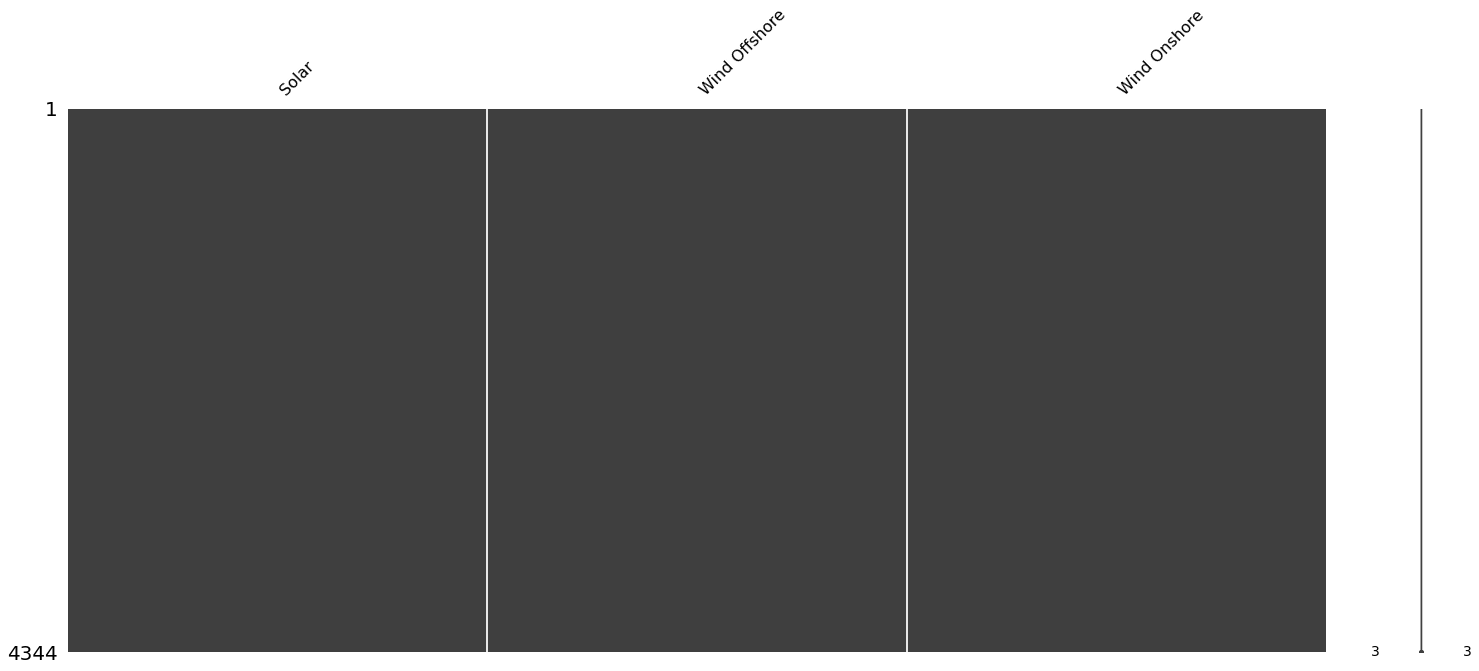

#null  %null
Solar              0 0.0000
Wind Offshore      0 0.0000
Wind Onshore       0 0.0000

In [21]:
#Check for null values

check_nulls(germany_df)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>], dtype=object)

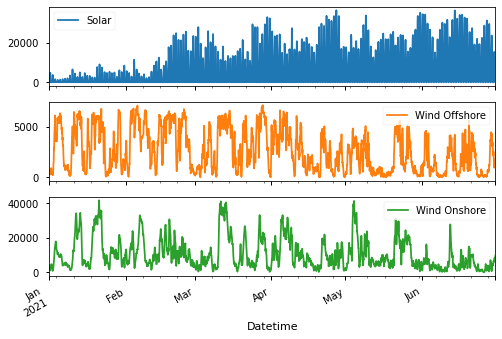

In [22]:
#Plot all time series
germany_df.plot(subplots=True)

From the plots above, we can see observe several things. Solar power has a very consistent cycle, producing high amounts of energy during daylight hours in spring, summer and fall. Wind, both on shore and offshore, has much more variable production, but is much more consistent through out the year, as the change in season does not affect it to the same degree as it does solar production.

### Solar Modeling

<AxesSubplot:xlabel='Datetime'>

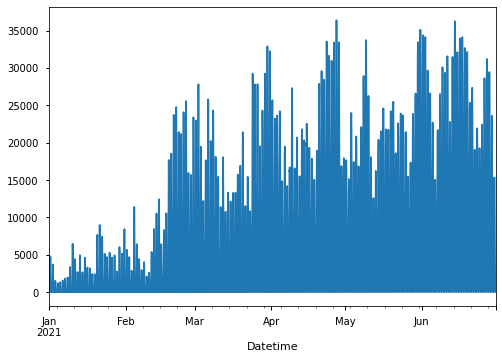

In [23]:
#Create solar energy time series and plot

germany_solar_ts = germany_df['Solar']
germany_solar_ts.plot()

In [24]:
germany_solar_ts.head()

Datetime
2021-01-01 00:00:00+00:00   0.0000
2021-01-01 01:00:00+00:00   0.0000
2021-01-01 02:00:00+00:00   0.0000
2021-01-01 03:00:00+00:00   0.0000
2021-01-01 04:00:00+00:00   0.0000
Freq: H, Name: Solar, dtype: float64

In [25]:
germany_solar_ts.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-06-30 14:00:00+00:00', '2021-06-30 15:00:00+00:00',
               '2021-06-30 16:00:00+00:00', '2021-06-30 17:00:00+00:00',
               '2021-06-30 18:00:00+00:00', '2021-06-30 19:00:00+00:00',
               '2021-06-30 20:00:00+00:00', '2021-06-30 21:00:00+00:00',
               '2021-06-30 22:00:00+00:00', '2021-06-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=4344, freq='H')

In [26]:
#Create function to create train test split
def train_test_split(ts):
    
    tts_cutoff = round(len(ts)*0.80)
    display(tts_cutoff)

    ## Use the tts cutoff to do Train test split and plot
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]
    
    return train, test

In [27]:
#Create train and test sets

train, test = train_test_split(germany_solar_ts)

3475

In [28]:
#Create function to plot train test split for the time series
def plot_train_test_split(train, test):
    
    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    
    return ax

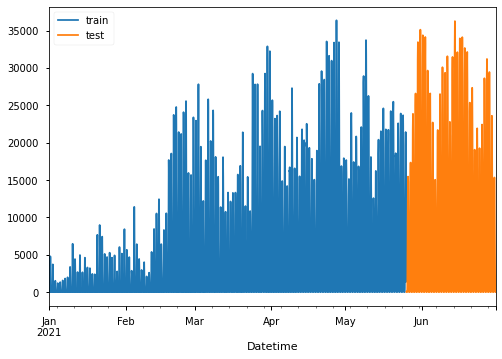

In [29]:
#Plot train and test sets

plot_train_test_split(train, test);

In [30]:
#Create Dickey Fuller Test test function
def adfuller_test_df(ts,index=['AD Fuller Results']):
    
    """Adapted from https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_4/topic_38_time_series_models/ts_functions.py
    Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    
    df_res = tsa.stattools.adfuller(ts)

    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    if isinstance(index,str):
        index = [index]
    res_df = pd.DataFrame(res,index=index)
    res_df = res_df[['Test Statistic','#Lags Used',
                     '# of Observations Used','p-value','p<.05',
                    'Stationary?']]
    return res_df

In [31]:
#Create Stationarity evaluation function
def stationarity_check(TS,window=4,plot=True,index=['AD Fuller Results']):
    """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller_test_df(TS,index=index)
    
    if plot:
        
        ## Building in contingency if not a series with a freq
        try: 
            freq = TS.index.freq
        except:
            freq = 'N/A'
            
        # Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        plt.plot(TS, color='blue',label=f'Original (freq={freq}')
        plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
        plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        display(dftest)
        plt.show(block=False)
        
    return dftest

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.8081          29  ...  False        False

[1 rows x 6 columns]

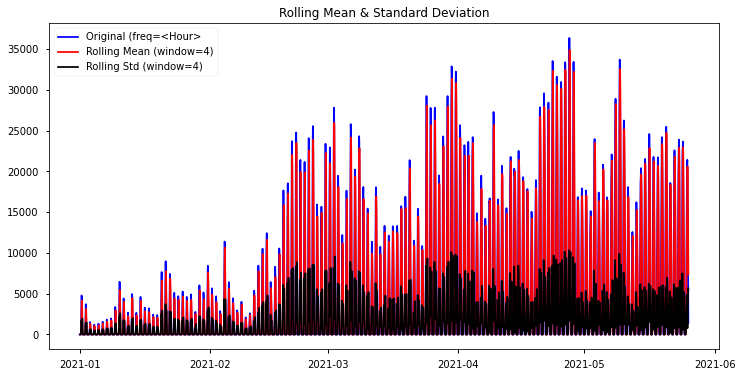

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.8081          29  ...  False        False

[1 rows x 6 columns]

In [32]:
#Check time series for stationarity
stationarity_check(train)

From the high p value, we can determine that the time series is stationary and requires transformation

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results        -15.8454          28  ...   True         True

[1 rows x 6 columns]

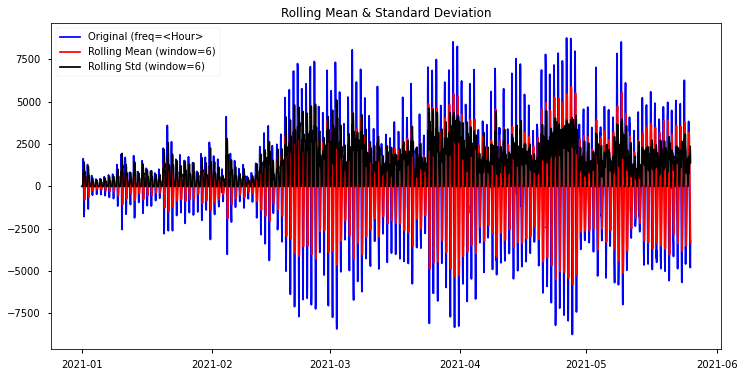

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results        -15.8454          28  ...   True         True

[1 rows x 6 columns]

In [33]:
#Check if differencing time series will result in stationarity
stationarity_check(train.diff().dropna(), window=6)

From the low p value, we can determine that the time series is stationary after differencing

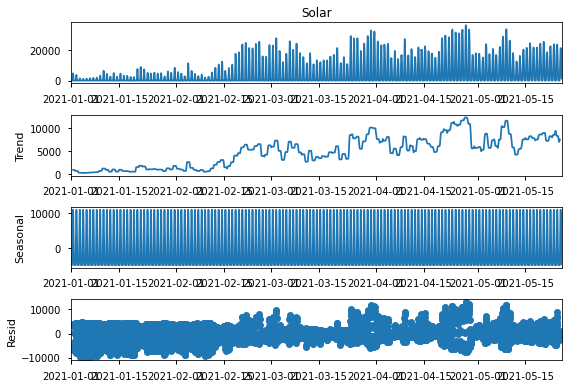

In [34]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

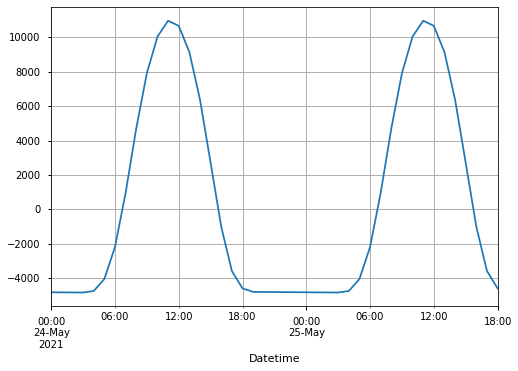

In [35]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

From the plot above, we can see that the period of seasonality in the time series is 24 hours

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=63789.767, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=57733.231, Time=5.73 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=63787.767, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=59949.591, Time=0.54 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=55992.880, Time=14.73 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=54238.688, Time=5.62 sec
 ARIMA(0,1,1)(2,0,0)[24] intercept   : AIC=53771.451, Time=33.89 sec
 ARIMA(0,1,1)(2,0,1)[24] intercept   : AIC=inf, Time=26.87 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=28.69 sec
 ARIMA(1,1,1)(2,0,0)[24] intercept   : AIC=52869.046, Time=54.24 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=53318.050, Time=7.04 sec
 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=inf, Time=44.13 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=52724.528, Time=23.29 sec
 ARIMA(1,1,1)(0,0,1)[2

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,0)(1,0,2)[24]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pmdarima\arima\arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3475
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 24)   Log Likelihood              -26221.841
Date:                                 Wed, 28 Jul 2021   AIC                          52457.682
Time:                                         11:02:27   BIC                          52500.754
Sample:                                              0   HQIC                         52473.060
                                                - 3475                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0107      0.006      1.703      0.089      -0.002       0.023
ar.L1          1.1043      0.008    131.632      0.000       1.088       1.121
ar.L2         -0.4652      0.009    -51.849      0.000      -0.483      -0.448
ar.S.L24       1.0000   1.88e-05   5.32e+04      0.000       1.000       1.000
ma.S.L24      -0.6149      0.007    -90.444      0.000      -0.628      -0.602
ma.S.L48      -0.1313      0.004    -35.971      0.000      -0.138      -0.124
sigma2      2.034e+05   2.55e-09   7.98e+13      0.000    2.03e+05    2.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              5157.71
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               5.30   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.13e+28. Standard errors may be unstable.
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


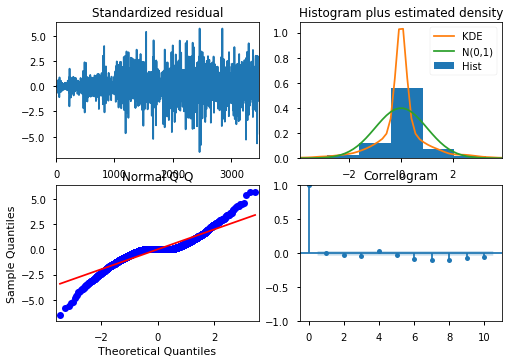

In [36]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

From the auto arima grid search above, we can see the optimal order for the model is (2,1,0)(1,0,2) [24]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Solar   No. Observations:                 3475
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 24)   Log Likelihood              -25789.942
Date:                                 Wed, 28 Jul 2021   AIC                          51591.884
Time:                                         11:02:54   BIC                          51628.717
Sample:                                     01-01-2021   HQIC                         51605.044
                                          - 05-25-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1056      0.008    131.610      0.000       1.089       1.122
ar.L2         -0.4682      0.009    -52.894      0.000      -0.486      -0.451
ar.S.L24       0.9921      0.002    550.431      0.000       0.989       0.996
ma.S.L24      -0.5941      0.010    -61.550      0.000      -0.613      -0.575
ma.S.L48      -0.1181      0.010    -11.329      0.000      -0.139      -0.098
sigma2      2.025e+05   2503.681     80.877      0.000    1.98e+05    2.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              4921.26
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.33   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


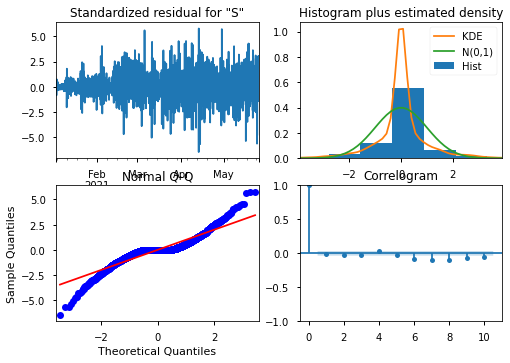

In [37]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

The model above has significant p values and acceptable histogram and residuals plats. The correlogram also shows acceptable levels of correlation. We will now fit this model on the whole time series.

In [38]:
#Create function to retrieve forecast and create data frame

def retrieve_forecast(model, steps):
    
    forecast = model.get_forecast(steps=steps)
    forecast_df = forecast.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df['Forecast'] = forecast.predicted_mean
    
    return forecast_df

In [39]:
#Get forecast for test set

forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI  Forecast
2021-05-25 19:00:00+00:00    -832.6016    931.3233   49.3608
2021-05-25 20:00:00+00:00   -2006.4066   2105.2479   49.4207
2021-05-25 21:00:00+00:00   -3082.3471   3425.2888  171.4709
2021-05-25 22:00:00+00:00   -4009.3864   4577.0627  283.8381
2021-05-25 23:00:00+00:00   -4773.3329   5475.1752  350.9212
...                                ...         ...       ...
2021-06-30 19:00:00+00:00 -436010.7088 442345.7155 3167.5034
2021-06-30 20:00:00+00:00 -436686.4470 442972.1949 3142.8739
2021-06-30 21:00:00+00:00 -437318.4684 443655.7653 3168.6485
2021-06-30 22:00:00+00:00 -437954.7691 444339.5230 3192.3769
2021-06-30 23:00:00+00:00 -438599.6092 445012.6936 3206.5422

[869 rows x 3 columns]

In [40]:
#Create function to plot training data and forecast

def plot_train_test_forecast(train, test, forecast_df):
    ### Plot training data, test data, and forecast (with upper/,lower ci) 
    fig,ax = plt.subplots(figsize=(10,6))


    # Plotting Training and test data
    train.plot(label='Training Data')
    test.plot(label='Test Data')

    ## Plotting Forecast and CI
    forecast = forecast_df['Forecast']
    LowerCI = forecast_df['Lower CI']
    UpperCI = forecast_df['Upper CI']
    forecast.plot(ax=ax,label='Forecast')
    ax.fill_between(forecast_df.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)

    ax.set(ylabel='Value')
    ax.legend()
    
    return fig, ax

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Datetime', ylabel='Value'>)

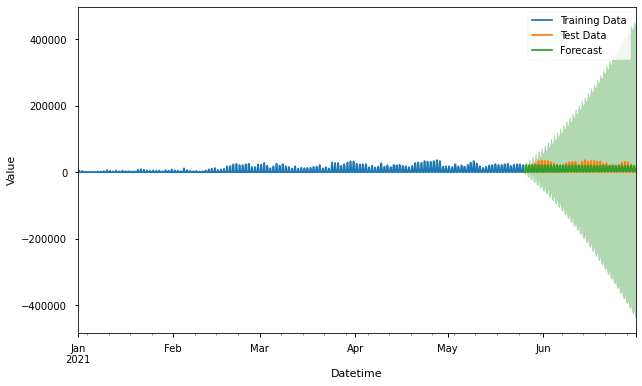

In [41]:
plot_train_test_forecast(train, test, forecast_df)

The forecast and the test set match fairly closely. The test set is also within the forecast confidence interval.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Solar   No. Observations:                 4344
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 24)   Log Likelihood              -32415.158
Date:                                 Wed, 28 Jul 2021   AIC                          64842.316
Time:                                         11:03:17   BIC                          64880.506
Sample:                                     01-01-2021   HQIC                         64855.805
                                          - 06-30-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0918      0.007    147.701      0.000       1.077       1.106
ar.L2         -0.4422      0.008    -54.716      0.000      -0.458      -0.426
ar.S.L24       0.9937      0.001    663.952      0.000       0.991       0.997
ma.S.L24      -0.6066      0.009    -68.101      0.000      -0.624      -0.589
ma.S.L48      -0.1308      0.010    -13.492      0.000      -0.150      -0.112
sigma2      2.104e+05   2262.521     93.007      0.000    2.06e+05    2.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):              8052.46
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


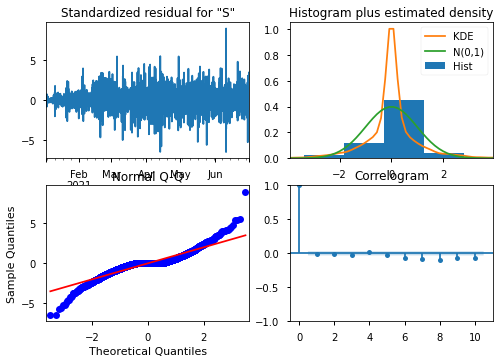

In [42]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(germany_solar_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

The model above has significant p values and acceptable histogram and residuals plats. The correlogram also shows acceptable levels of correlation. We will now fit this model on the whole time series.

In [43]:
#Retrieve forecast for the next month
solar_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
solar_forecast_df

Lower CI    Upper CI  Forecast
2021-07-01 00:00:00+00:00    -899.0880    899.0880    0.0000
2021-07-01 01:00:00+00:00   -2084.5384   2084.5384    0.0000
2021-07-01 02:00:00+00:00   -3297.2955   3297.2955    0.0000
2021-07-01 03:00:00+00:00   -4284.5172   4440.7978   78.1403
2021-07-01 04:00:00+00:00   -4294.0911   6170.0546  937.9818
...                                ...         ...       ...
2021-07-30 19:00:00+00:00 -344635.0735 345072.0093  218.4679
2021-07-30 20:00:00+00:00 -345451.1254 345451.9600    0.4173
2021-07-30 21:00:00+00:00 -346048.5134 346048.5134    0.0000
2021-07-30 22:00:00+00:00 -346644.4584 346644.4584    0.0000
2021-07-30 23:00:00+00:00 -347239.3822 347239.3822    0.0000

[720 rows x 3 columns]

In [44]:
#Create function to plot whole time series data and forecast

def plot_time_series_forecast(ts, forecast_df, save=True):
    ### Plot training data, test data, and forecast (with upper/,lower ci) 
    fig,ax = plt.subplots(figsize=(10,6))


    # Plotting time series data
    ts.plot(label='Training Data')
    ax.axvline(ts.index[-1],ls=':')

    ## Plotting Forefcast and CI
    forecast = forecast_df['Forecast']
    LowerCI = forecast_df['Lower CI']
    UpperCI = forecast_df['Upper CI']
    forecast.plot(ax=ax,label='Forecast')
    ax.fill_between(forecast_df.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)

    ax.set(ylabel='Value')
    ax.legend()
    
    ax.set_title(f'{ts.name} Forecast')
    
    if save:
        file_name = f'images/{ts.name}_forecast.png'
        fig.savefig(file_name, dpi=300)
        print(f'Figure save as {file_name}')
    
    return fig, ax

Figure save as images/Solar_forecast.png


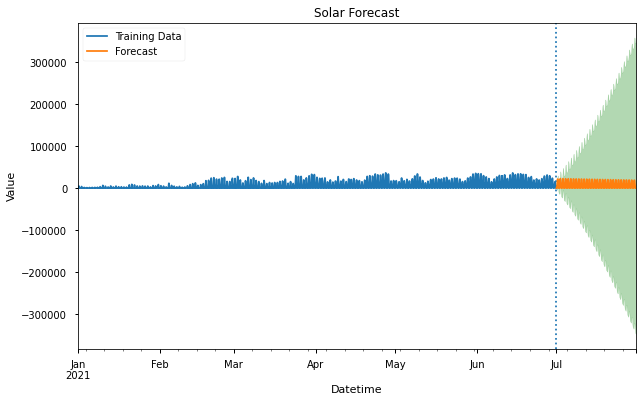

In [45]:
fig, ax = plot_time_series_forecast(germany_solar_ts, solar_forecast_df)

### Onshore Wind Modeling

<AxesSubplot:xlabel='Datetime'>

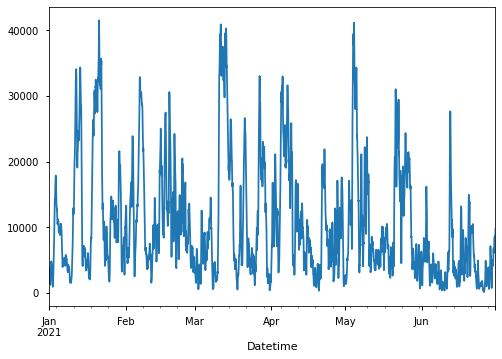

In [46]:
germany_wind_ts = germany_df['Wind Onshore']
germany_wind_ts.plot()

In [47]:
train, test = train_test_split(germany_wind_ts)

3475

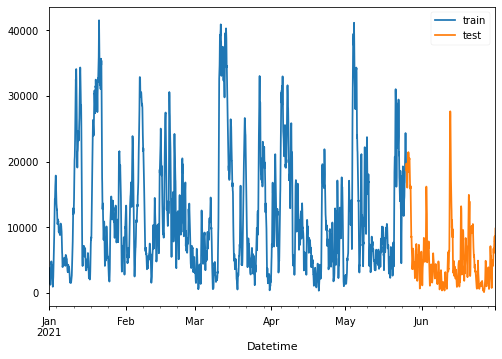

In [48]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -5.9947          27  ...   True         True

[1 rows x 6 columns]

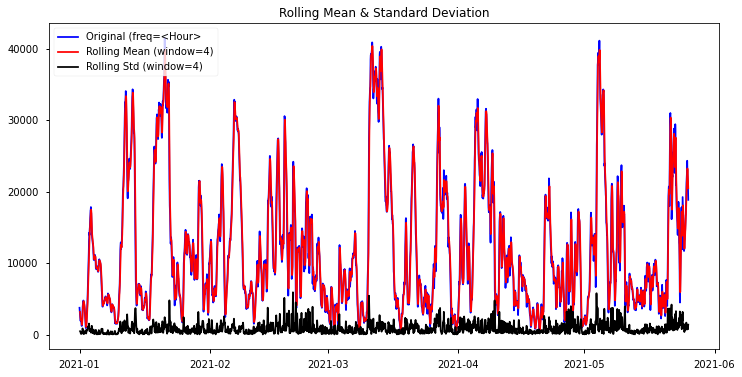

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -5.9947          27  ...   True         True

[1 rows x 6 columns]

In [49]:
#Check time series for stationarity
stationarity_check(train)

From the low p value, we can determine that the time series is stationary

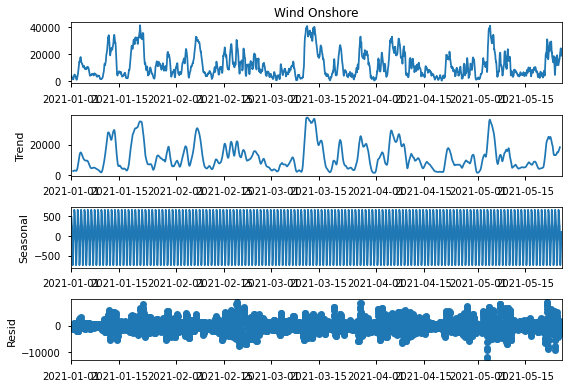

In [50]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

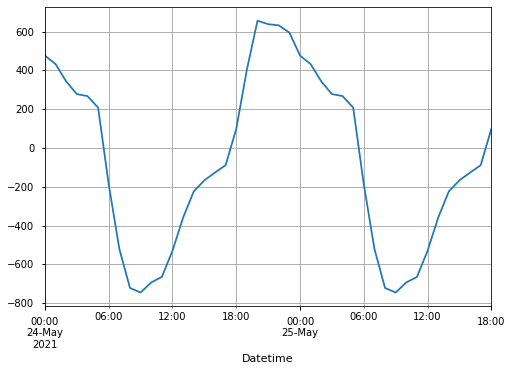

In [51]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

From the plot above, we can see that the period of seasonality in the time series is 24 hours

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[10] intercept   : AIC=73199.283, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[10] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[10] intercept   : AIC=66370.380, Time=2.07 sec
 ARIMA(0,0,0)(0,0,0)[10]             : AIC=76746.103, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[10] intercept   : AIC=68596.547, Time=0.71 sec
 ARIMA(0,0,1)(1,0,1)[10] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(0,0,1)(0,0,2)[10] intercept   : AIC=inf, Time=8.64 sec
 ARIMA(0,0,1)(1,0,0)[10] intercept   : AIC=67474.340, Time=3.16 sec
 ARIMA(0,0,1)(1,0,2)[10] intercept   : AIC=65694.175, Time=8.19 sec
 ARIMA(0,0,1)(2,0,2)[10] intercept   : AIC=inf, Time=17.52 sec
 ARIMA(0,0,1)(2,0,1)[10] intercept   : AIC=inf, Time=9.95 sec
 ARIMA(0,0,0)(1,0,2)[10] intercept   : AIC=71225.722, Time=2.82 sec
 ARIMA(1,0,1)(1,0,2)[10] intercept   : AIC=56109.241, Time=8.10 sec
 ARIMA(1,0,1)(0,0,2)[10] intercept   : AIC=56102.112, Time=9.21 sec
 ARIMA(1,0,1)(0,0,1)[10] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3475
Model:             SARIMAX(3, 0, 1)x(2, 0, [1, 2], 10)   Log Likelihood              -27679.557
Date:                                 Wed, 28 Jul 2021   AIC                          55379.114
Time:                                         11:08:53   BIC                          55440.648
Sample:                                              0   HQIC                         55401.083
                                                - 3475                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    111.0080     58.868      1.886      0.059      -4.372     226.388
ar.L1          1.9718      0.084     23.365      0.000       1.806       2.137
ar.L2         -1.2306      0.146     -8.429      0.000      -1.517      -0.944
ar.L3          0.2531      0.063      4.044      0.000       0.130       0.376
ma.L1         -0.1479      0.087     -1.709      0.088      -0.318       0.022
ar.S.L10      -0.9177      0.091    -10.096      0.000      -1.096      -0.740
ar.S.L20      -0.7401      0.089     -8.344      0.000      -0.914      -0.566
ma.S.L10       0.8783      0.099      8.857      0.000       0.684       1.073
ma.S.L20       0.6758      0.096      7.003      0.000       0.487       0.865
sigma2      4.892e+05   7672.755     63.752      0.000    4.74e+05    5.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):              1624.85
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.92e+14. Standard errors may be unstable.
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


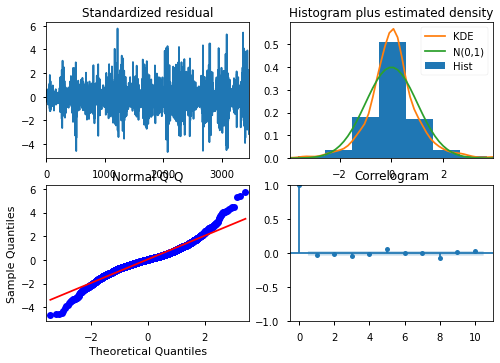

In [52]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=10, trace=True)
display(model.summary())
model.plot_diagnostics();

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            Wind Onshore   No. Observations:                 3475
Model:             SARIMAX(3, 0, 1)x(2, 0, [1, 2], 10)   Log Likelihood              -27705.290
Date:                                 Wed, 28 Jul 2021   AIC                          55428.581
Time:                                         11:09:20   BIC                          55483.961
Sample:                                     01-01-2021   HQIC                         55448.353
                                          - 05-25-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9341      0.041     47.405      0.000       1.854       2.014
ar.L2         -1.1741      0.071    -16.593      0.000      -1.313      -1.035
ar.L3          0.2371      0.031      7.669      0.000       0.176       0.298
ma.L1         -0.1204      0.039     -3.090      0.002      -0.197      -0.044
ar.S.L10       0.0436      0.030      1.458      0.145      -0.015       0.102
ar.S.L20       0.9560      0.034     28.350      0.000       0.890       1.022
ma.S.L10      -0.0554      0.037     -1.496      0.135      -0.128       0.017
ma.S.L20      -0.9433      0.044    -21.523      0.000      -1.029      -0.857
sigma2      4.934e+05   2.18e-07   2.26e+12      0.000    4.93e+05    4.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1633.42
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+27. Standard errors may be unstable.
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


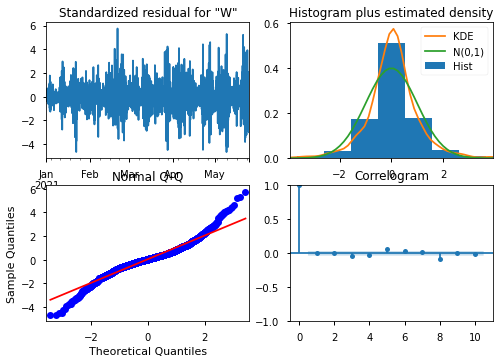

In [53]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [54]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI   Upper CI   Forecast
2021-05-25 19:00:00+00:00  16934.3804 19688.3565 18311.3684
2021-05-25 20:00:00+00:00  15131.8965 20835.7260 17983.8113
2021-05-25 21:00:00+00:00  13432.0659 22025.3985 17728.7322
2021-05-25 22:00:00+00:00  11845.5700 23069.2713 17457.4207
2021-05-25 23:00:00+00:00  10527.7227 24083.5286 17305.6256
...                               ...        ...        ...
2021-06-30 19:00:00+00:00 -25702.4082 32674.8912  3486.2415
2021-06-30 20:00:00+00:00 -25707.2160 32670.0944  3481.4392
2021-06-30 21:00:00+00:00 -25703.8829 32673.4393  3484.7782
2021-06-30 22:00:00+00:00 -25700.6134 32676.7193  3488.0529
2021-06-30 23:00:00+00:00 -25713.3027 32664.0391  3475.3682

[869 rows x 3 columns]

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Datetime', ylabel='Value'>)

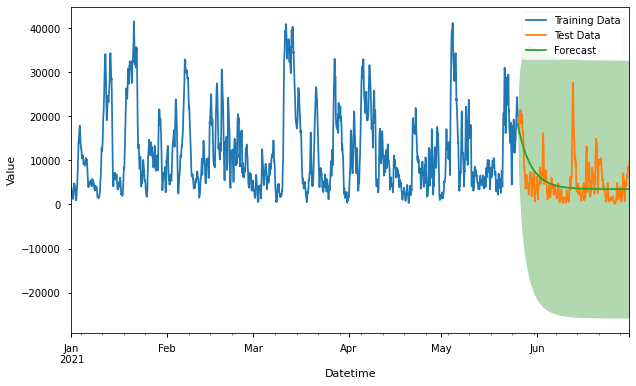

In [55]:
plot_train_test_forecast(train, test, forecast_df)

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            Wind Onshore   No. Observations:                 4344
Model:             SARIMAX(3, 0, 1)x(2, 0, [1, 2], 10)   Log Likelihood              -34448.066
Date:                                 Wed, 28 Jul 2021   AIC                          68914.131
Time:                                         11:09:39   BIC                          68971.520
Sample:                                     01-01-2021   HQIC                         68934.389
                                          - 06-30-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8512      0.069     27.021      0.000       1.717       1.985
ar.L2         -1.0447      0.117     -8.940      0.000      -1.274      -0.816
ar.L3          0.1891      0.049      3.843      0.000       0.093       0.286
ma.L1         -0.0548      0.070     -0.788      0.431      -0.191       0.082
ar.S.L10       0.0254      0.034      0.752      0.452      -0.041       0.092
ar.S.L20       0.9741      0.034     28.734      0.000       0.908       1.041
ma.S.L10      -0.0291      0.038     -0.765      0.445      -0.104       0.046
ma.S.L20      -0.9676      0.038    -25.201      0.000      -1.043      -0.892
sigma2      4.541e+05   8.81e-08   5.16e+12      0.000    4.54e+05    4.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              2486.58
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.23e+28. Standard errors may be unstable.
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


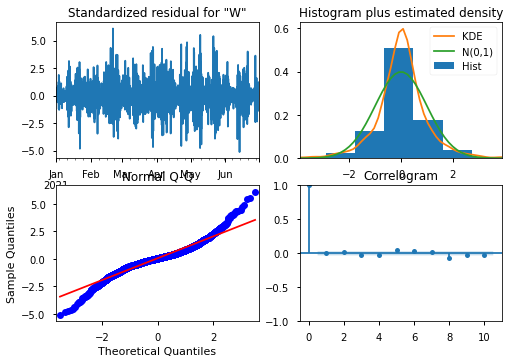

In [56]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(germany_wind_ts, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [57]:
#Retrieve forecast for the next three days
onshore_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
onshore_forecast_df

Lower CI   Upper CI   Forecast
2021-07-01 00:00:00+00:00   8777.9303 11420.1748 10099.0526
2021-07-01 01:00:00+00:00   7538.3783 12970.7551 10254.5667
2021-07-01 02:00:00+00:00   6285.2315 14398.5755 10341.9035
2021-07-01 03:00:00+00:00   5106.2764 15626.3194 10366.2979
2021-07-01 04:00:00+00:00   4072.8401 16708.1946 10390.5173
...                               ...        ...        ...
2021-07-30 19:00:00+00:00 -16118.4757 30551.7332  7216.6287
2021-07-30 20:00:00+00:00 -16115.2764 30554.9869  7219.8552
2021-07-30 21:00:00+00:00 -16090.8168 30579.5019  7244.3425
2021-07-30 22:00:00+00:00 -16094.2018 30576.1679  7240.9830
2021-07-30 23:00:00+00:00 -16117.0029 30553.4133  7218.2052

[720 rows x 3 columns]

Figure save as images/Wind Onshore_forecast.png


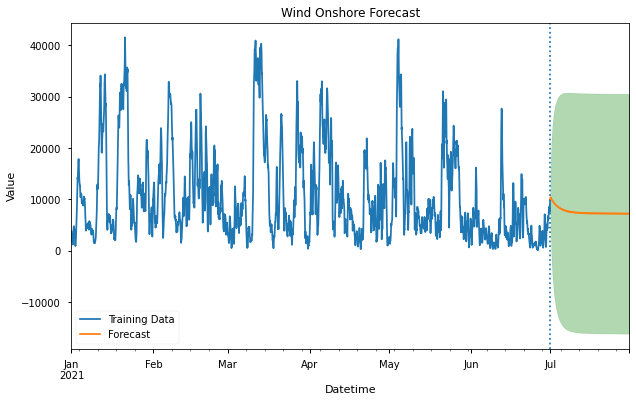

In [58]:
fig, ax = plot_time_series_forecast(germany_wind_ts, onshore_forecast_df)

### Offshore Wind Modeling

<AxesSubplot:xlabel='Datetime'>

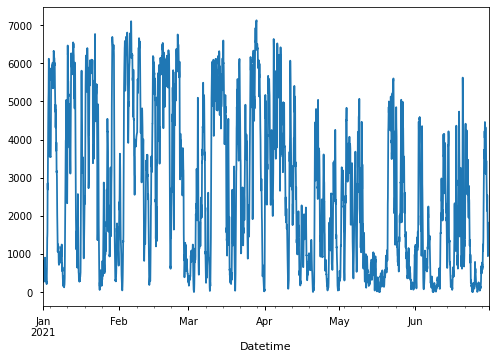

In [59]:
germany_offshore_wind_ts = germany_df['Wind Offshore']
germany_offshore_wind_ts.plot()

In [60]:
train, test = train_test_split(germany_offshore_wind_ts)

3475

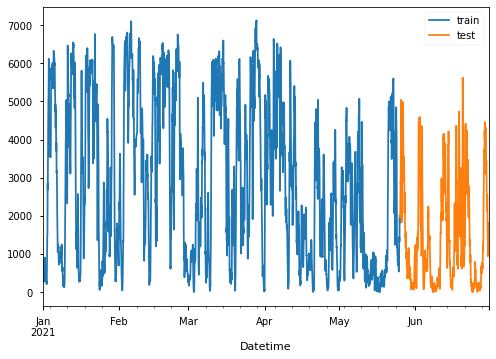

In [61]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -7.7666           2  ...   True         True

[1 rows x 6 columns]

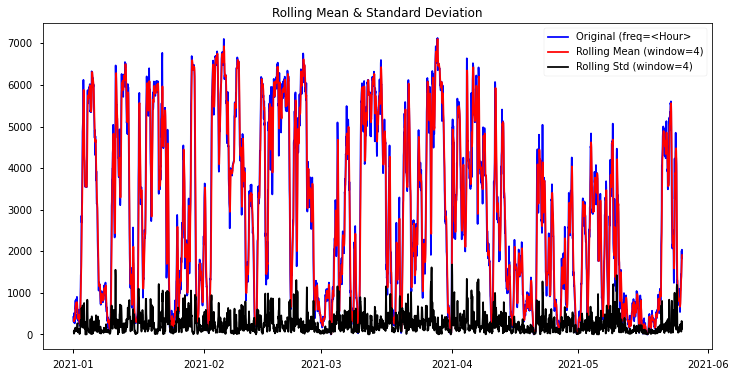

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -7.7666           2  ...   True         True

[1 rows x 6 columns]

In [62]:
#Check time series for stationarity
stationarity_check(train)

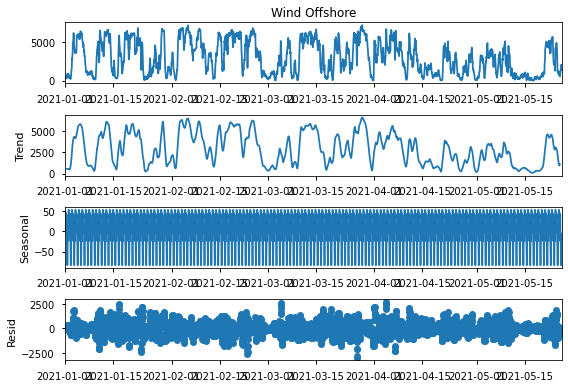

In [63]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

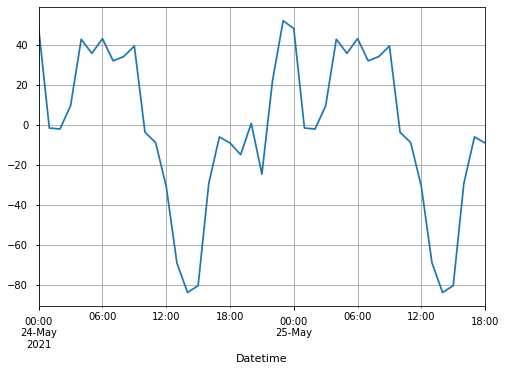

In [64]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=50173.538, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=49629.497, Time=1.40 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=49745.167, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=50171.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=49627.615, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=49629.496, Time=1.07 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=49631.509, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=49612.821, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=49614.784, Time=1.84 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=49614.784, Time=1.26 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=49616.792, Time=1.68 sec
 ARIMA(3,1,0)(0,0,0)[24] intercept   : AIC=49613.664, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=49613.687, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=49614.685, Time=0.23 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3475
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -24802.412
Date:                Wed, 28 Jul 2021   AIC                          49610.823
Time:                        11:09:55   BIC                          49629.283
Sample:                             0   HQIC                         49617.414
                               - 3475                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3555      0.011     32.097      0.000       0.334       0.377
ar.L2          0.0695      0.012      5.779      0.000       0.046       0.093
sigma2      9.311e+04   1184.260     78.620      0.000    9.08e+04    9.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3865.66
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


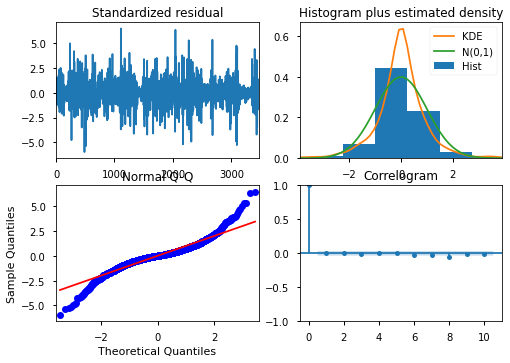

In [65]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Wind Offshore   No. Observations:                 3475
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -24802.412
Date:                Wed, 28 Jul 2021   AIC                          49610.823
Time:                        11:09:55   BIC                          49629.283
Sample:                    01-01-2021   HQIC                         49617.414
                         - 05-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3555      0.011     32.097      0.000       0.334       0.377
ar.L2          0.0695      0.012      5.779      0.000       0.046       0.093
sigma2      9.311e+04   1184.260     78.620      0.000    9.08e+04    9.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3865.66
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


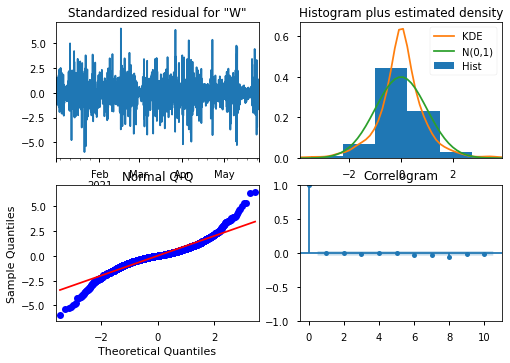

In [66]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [67]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI   Upper CI  Forecast
2021-05-25 19:00:00+00:00   1499.0452  2695.1445 2097.0948
2021-05-25 20:00:00+00:00   1126.5185  3141.2656 2133.8921
2021-05-25 21:00:00+00:00    781.7899  3520.7805 2151.2852
2021-05-25 22:00:00+00:00    473.5921  3846.4554 2160.0237
2021-05-25 23:00:00+00:00    197.3997  4131.2764 2164.3380
...                               ...        ...       ...
2021-06-30 19:00:00+00:00 -28391.3214 32728.4840 2168.5813
2021-06-30 20:00:00+00:00 -28409.0111 32746.1738 2168.5813
2021-06-30 21:00:00+00:00 -28426.6907 32763.8533 2168.5813
2021-06-30 22:00:00+00:00 -28444.3599 32781.5226 2168.5813
2021-06-30 23:00:00+00:00 -28462.0190 32799.1817 2168.5813

[869 rows x 3 columns]

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Datetime', ylabel='Value'>)

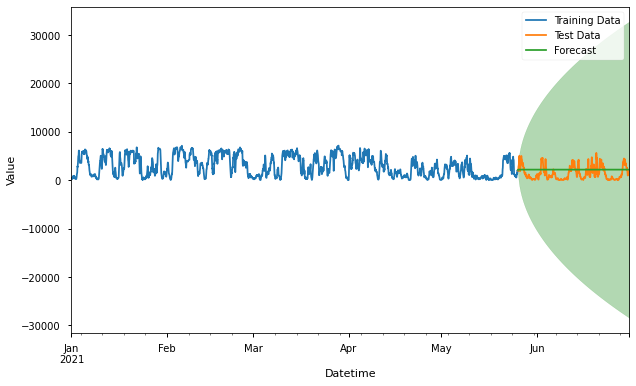

In [68]:
plot_train_test_forecast(train, test, forecast_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Wind Offshore   No. Observations:                 4344
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -30930.313
Date:                Wed, 28 Jul 2021   AIC                          61866.627
Time:                        11:09:56   BIC                          61885.756
Sample:                    01-01-2021   HQIC                         61873.379
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3602      0.009     38.293      0.000       0.342       0.379
ar.L2          0.0537      0.010      5.165      0.000       0.033       0.074
sigma2      8.988e+04    956.909     93.931      0.000     8.8e+04    9.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7026.30
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.09
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


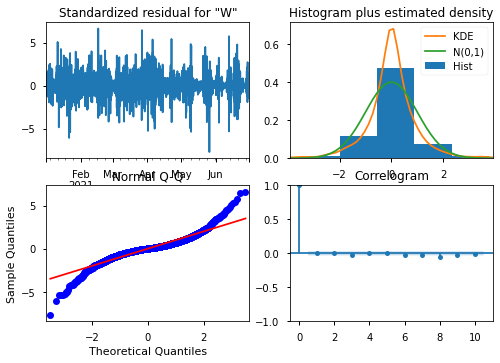

In [69]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(germany_offshore_wind_ts, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [70]:
#Retrieve forecast for the next three days
offshore_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
offshore_forecast_df

Lower CI   Upper CI  Forecast
2021-07-01 00:00:00+00:00   1220.0679  2395.2868 1807.6773
2021-07-01 01:00:00+00:00    849.4767  2833.5712 1841.5239
2021-07-01 02:00:00+00:00    513.0504  3201.5444 1857.2974
2021-07-01 03:00:00+00:00    214.5105  3515.0838 1864.7971
2021-07-01 04:00:00+00:00    -51.5954  3788.2871 1868.3459
...                               ...        ...       ...
2021-07-30 19:00:00+00:00 -24931.8550 28674.9341 1871.5396
2021-07-30 20:00:00+00:00 -24950.6018 28693.6809 1871.5396
2021-07-30 21:00:00+00:00 -24969.3355 28712.4147 1871.5396
2021-07-30 22:00:00+00:00 -24988.0562 28731.1353 1871.5396
2021-07-30 23:00:00+00:00 -25006.7638 28749.8430 1871.5396

[720 rows x 3 columns]

Figure save as images/Wind Offshore_forecast.png


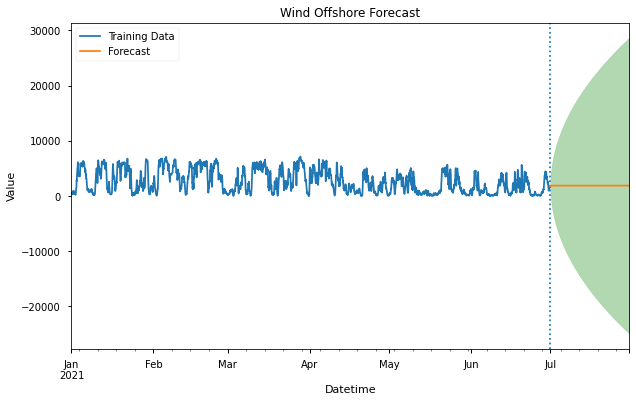

In [71]:
fig, ax = plot_time_series_forecast(germany_offshore_wind_ts, offshore_forecast_df)

### iNTERPRET

In [73]:
all_forecasts_df = pd.DataFrame()
all_forecasts_df['Solar Forecast'] = solar_forecast_df['Forecast']
all_forecasts_df['Onshore Wind Forecast'] = onshore_forecast_df['Forecast']
all_forecasts_df['Offshore Wind Forecast'] = offshore_forecast_df['Forecast']
all_forecasts_df.head()

Solar Forecast  ...  Offshore Wind Forecast
2021-07-01 00:00:00+00:00          0.0000  ...               1807.6773
2021-07-01 01:00:00+00:00          0.0000  ...               1841.5239
2021-07-01 02:00:00+00:00          0.0000  ...               1857.2974
2021-07-01 03:00:00+00:00         78.1403  ...               1864.7971
2021-07-01 04:00:00+00:00        937.9818  ...               1868.3459

[5 rows x 3 columns]

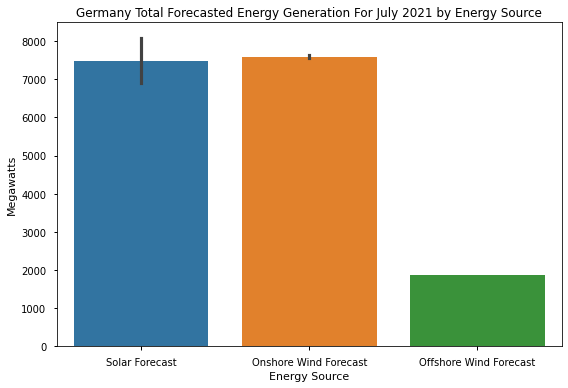

In [74]:
sns.barplot(data=all_forecasts_df, estimator=sum)
plt.title('Germany Total Forecasted Energy Generation For July 2021 by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Megawatts')
plt.tight_layout()
plt.savefig('images/Germany_forecast.png', dpi=300)

## France

### SCRUB/EXPLORE

In [75]:
france_df = pd.read_csv("data/FR_df.csv")
france_df.head()

Unnamed: 0  ...       Wind Onshore
0                        NaN  ...  Actual Aggregated
1  2021-01-01 01:00:00+01:00  ...             1075.0
2  2021-01-01 02:00:00+01:00  ...             1086.0
3  2021-01-01 03:00:00+01:00  ...             1149.0
4  2021-01-01 04:00:00+01:00  ...             1170.0

[5 rows x 14 columns]

In [76]:
france_df.tail()

Unnamed: 0 Biomass Fossil Gas  ...  Solar  Waste Wind Onshore
4339  2021-06-30 21:00:00+02:00   344.0     3217.0  ...  206.0  201.0       1403.0
4340  2021-06-30 22:00:00+02:00   344.0     3213.0  ...    0.0  190.0       1275.0
4341  2021-06-30 23:00:00+02:00   344.0     3188.0  ...    0.0  187.0       1238.0
4342  2021-07-01 00:00:00+02:00   358.0     2661.0  ...    0.0  198.0       1164.0
4343  2021-07-01 01:00:00+02:00   358.0     1638.0  ...    0.0  202.0       1100.0

[5 rows x 14 columns]

In [77]:
#Display DataFrame info

france_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Unnamed: 0                       4343 non-null   object
 1   Biomass                          4344 non-null   object
 2   Fossil Gas                       4344 non-null   object
 3   Fossil Hard coal                 4305 non-null   object
 4   Fossil Hard coal.1               40 non-null     object
 5   Fossil Oil                       4344 non-null   object
 6   Hydro Pumped Storage             2477 non-null   object
 7   Hydro Pumped Storage.1           1868 non-null   object
 8   Hydro Run-of-river and poundage  4344 non-null   object
 9   Hydro Water Reservoir            4344 non-null   object
 10  Nuclear                          4344 non-null   object
 11  Solar                            4344 non-null   object
 12  Waste                            4

In [78]:
#Drop first row of DataFrame

france_df = france_df.drop(0)
france_df.head()

Unnamed: 0 Biomass Fossil Gas  ... Solar  Waste Wind Onshore
1  2021-01-01 01:00:00+01:00   365.0     4265.0  ...   0.0  251.0       1075.0
2  2021-01-01 02:00:00+01:00   364.0     3876.0  ...   0.0  256.0       1086.0
3  2021-01-01 03:00:00+01:00   364.0     3610.0  ...   0.0  253.0       1149.0
4  2021-01-01 04:00:00+01:00   364.0     3472.0  ...   0.0  251.0       1170.0
5  2021-01-01 05:00:00+01:00   361.0     3464.0  ...   0.0  247.0       1190.0

[5 rows x 14 columns]

In [79]:
#Rename first column, will eventually become the index

france_df.rename(columns = {"Unnamed: 0": "Datetime"}, inplace=True)
france_df.head()

Datetime Biomass Fossil Gas  ... Solar  Waste Wind Onshore
1  2021-01-01 01:00:00+01:00   365.0     4265.0  ...   0.0  251.0       1075.0
2  2021-01-01 02:00:00+01:00   364.0     3876.0  ...   0.0  256.0       1086.0
3  2021-01-01 03:00:00+01:00   364.0     3610.0  ...   0.0  253.0       1149.0
4  2021-01-01 04:00:00+01:00   364.0     3472.0  ...   0.0  251.0       1170.0
5  2021-01-01 05:00:00+01:00   361.0     3464.0  ...   0.0  247.0       1190.0

[5 rows x 14 columns]

In [80]:
#Display dtypes, need to ensure 'Datetime' column is actually datetime dtype

france_df.dtypes

Datetime                           object
Biomass                            object
Fossil Gas                         object
Fossil Hard coal                   object
Fossil Hard coal.1                 object
Fossil Oil                         object
Hydro Pumped Storage               object
Hydro Pumped Storage.1             object
Hydro Run-of-river and poundage    object
Hydro Water Reservoir              object
Nuclear                            object
Solar                              object
Waste                              object
Wind Onshore                       object
dtype: object

In [81]:
#Change 'Datetime' dtype to datetime

france_df['Datetime'] = pd.to_datetime(france_df['Datetime'], utc=True)

france_df['Datetime'].head()

1   2021-01-01 00:00:00+00:00
2   2021-01-01 01:00:00+00:00
3   2021-01-01 02:00:00+00:00
4   2021-01-01 03:00:00+00:00
5   2021-01-01 04:00:00+00:00
Name: Datetime, dtype: datetime64[ns, UTC]

In [82]:
#Change index of DataFrame to 'Datetime' column to create time series

france_df = france_df.set_index("Datetime")
france_df.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-06-30 14:00:00+00:00', '2021-06-30 15:00:00+00:00',
               '2021-06-30 16:00:00+00:00', '2021-06-30 17:00:00+00:00',
               '2021-06-30 18:00:00+00:00', '2021-06-30 19:00:00+00:00',
               '2021-06-30 20:00:00+00:00', '2021-06-30 21:00:00+00:00',
               '2021-06-30 22:00:00+00:00', '2021-06-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=4343, freq=None)

In [83]:
#freq = 15T (15 minutes) so resample timeseries as hourly
france_df = france_df.resample('H').asfreq()
france_df.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-06-30 14:00:00+00:00', '2021-06-30 15:00:00+00:00',
               '2021-06-30 16:00:00+00:00', '2021-06-30 17:00:00+00:00',
               '2021-06-30 18:00:00+00:00', '2021-06-30 19:00:00+00:00',
               '2021-06-30 20:00:00+00:00', '2021-06-30 21:00:00+00:00',
               '2021-06-30 22:00:00+00:00', '2021-06-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=4344, freq='H')

In [84]:
#Drop unnecessary columns

france_df = france_df[['Solar', 'Wind Onshore']]
france_df.head()

Solar Wind Onshore
Datetime                                    
2021-01-01 00:00:00+00:00   0.0       1075.0
2021-01-01 01:00:00+00:00   0.0       1086.0
2021-01-01 02:00:00+00:00   0.0       1149.0
2021-01-01 03:00:00+00:00   0.0       1170.0
2021-01-01 04:00:00+00:00   0.0       1190.0

In [85]:
#Change dtypes from 'object' to 'float'

france_df = france_df.astype('float')

In [86]:
france_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344 entries, 2021-01-01 00:00:00+00:00 to 2021-06-30 23:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Solar         4343 non-null   float64
 1   Wind Onshore  4343 non-null   float64
dtypes: float64(2)
memory usage: 101.8 KB


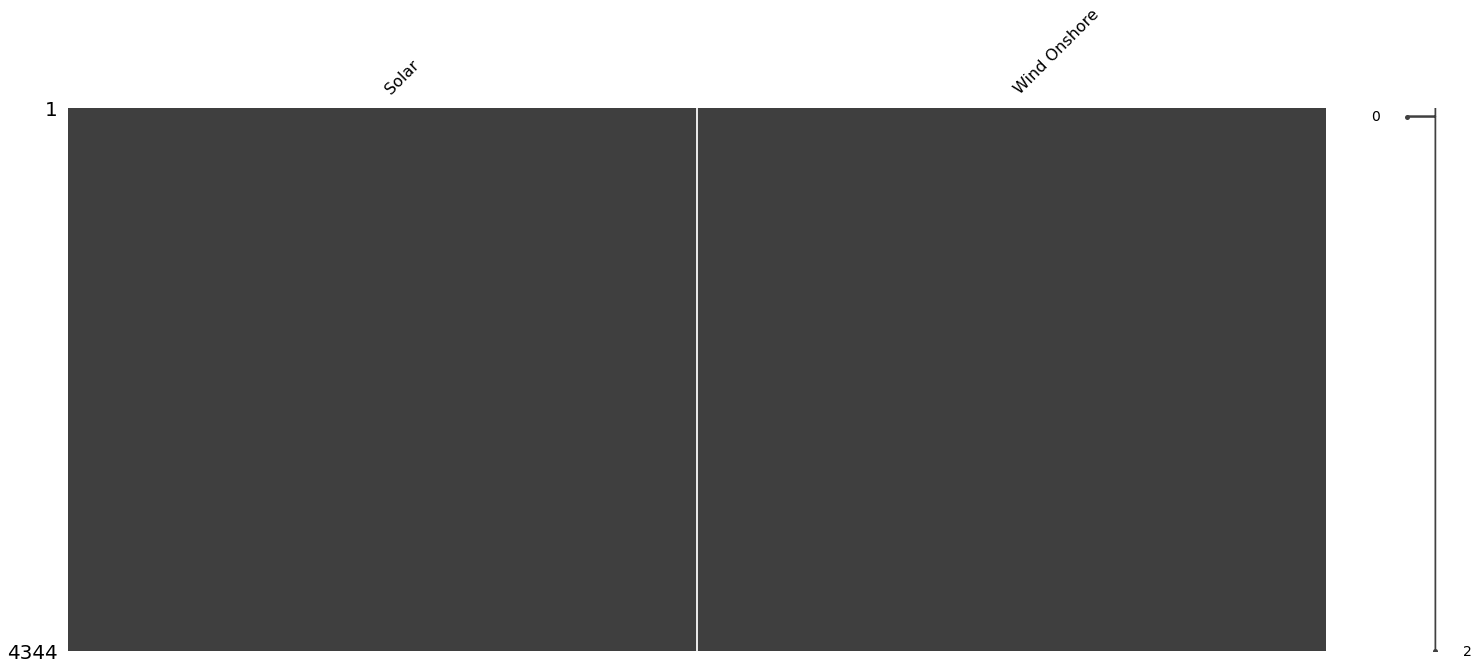

#null  %null
Solar             1 0.0200
Wind Onshore      1 0.0200

In [87]:
#Check for null values

check_nulls(france_df)

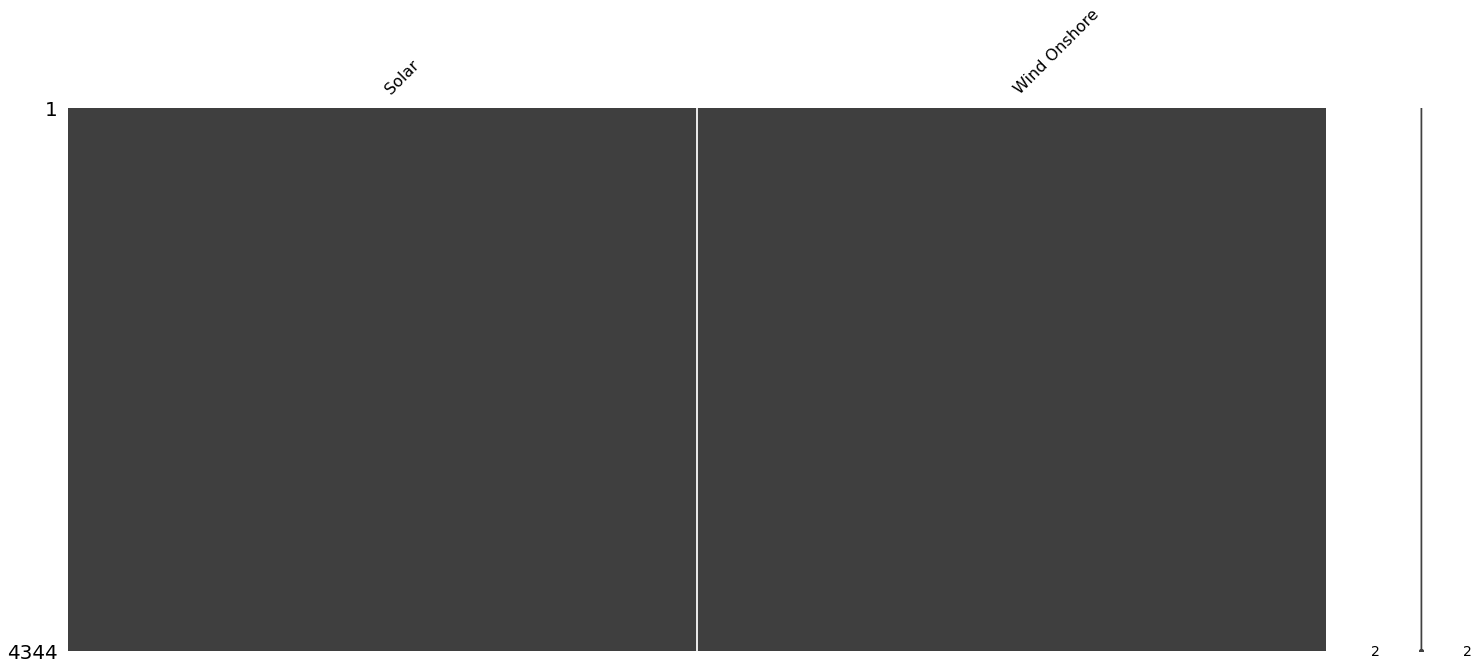

#null  %null
Solar             0 0.0000
Wind Onshore      0 0.0000

In [88]:
#Fill nulls
france_df.fillna(method="ffill", inplace=True)
check_nulls(france_df)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

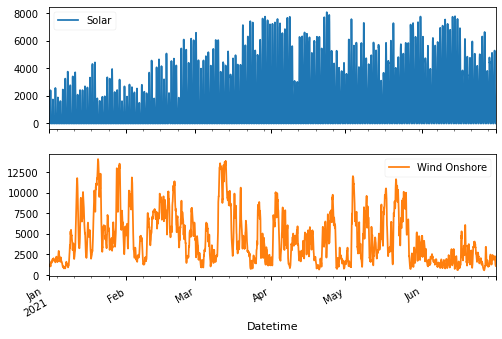

In [89]:
#Plot all time series
france_df.plot(subplots=True)

From the plots above, we can see observe several things. Solar power has a very consistent cycle, producing high amounts of energy during daylight hours in spring, summer and fall. Wind has much more variable production, but is much more consistent through out the year, as the change in season does not affect it to the same degree as it does solar production.

### Solar Modeling

<AxesSubplot:xlabel='Datetime'>

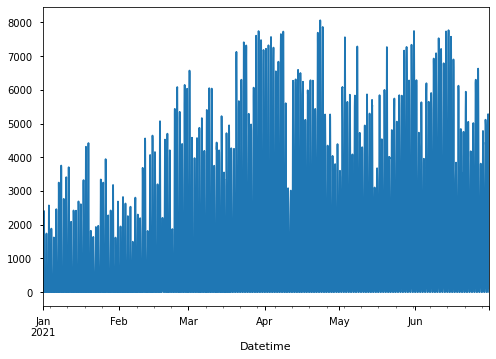

In [90]:
frace_solar_ts = france_df['Solar']
frace_solar_ts.plot()

In [91]:
train, test = train_test_split(frace_solar_ts)

3475

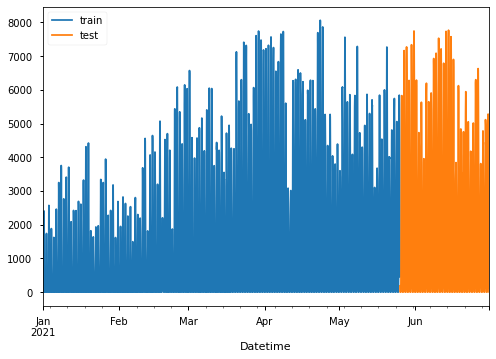

In [92]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.5509          29  ...   True         True

[1 rows x 6 columns]

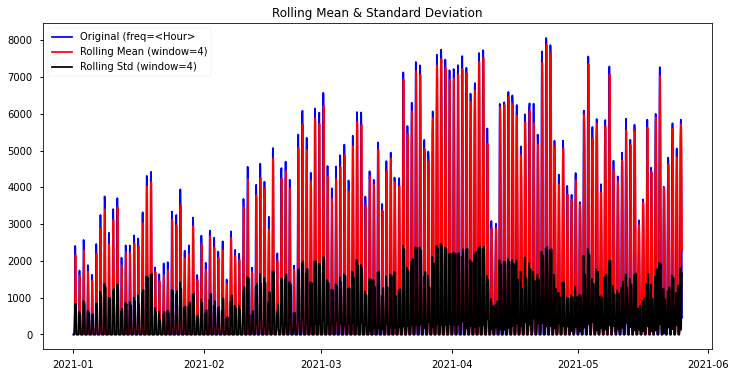

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.5509          29  ...   True         True

[1 rows x 6 columns]

In [93]:
#Check time series for stationarity
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results        -17.3823          27  ...   True         True

[1 rows x 6 columns]

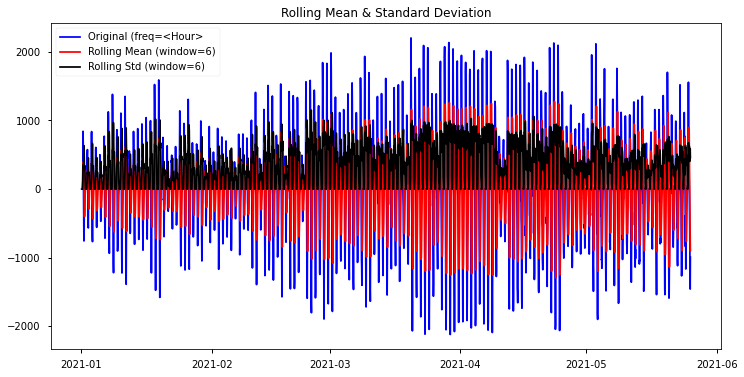

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results        -17.3823          27  ...   True         True

[1 rows x 6 columns]

In [94]:
#Check if differencing time series will result in stationarity
stationarity_check(train.diff().dropna(), window=6)

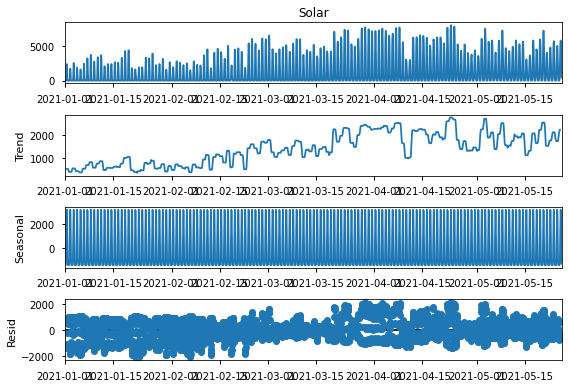

In [95]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

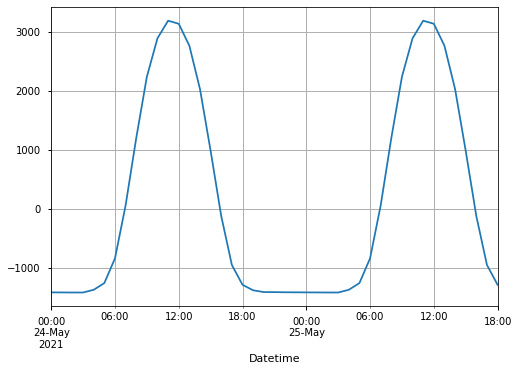

In [96]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=54717.521, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.33 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=49139.217, Time=5.30 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=54715.521, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=51198.733, Time=0.50 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=5.24 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=47807.614, Time=28.33 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=44999.306, Time=71.62 sec
 ARIMA(0,1,1)(2,0,2)[24] intercept   : AIC=inf, Time=71.78 sec
 ARIMA(0,1,1)(2,0,1)[24] intercept   : AIC=inf, Time=73.71 sec
 ARIMA(0,1,0)(1,0,2)[24] intercept   : AIC=inf, Time=81.00 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=57.21 sec
 ARIMA(0,1,2)(1,0,2)[24] intercept   : AIC=45439.129, Time=69.15 sec
 ARIMA(1,1,0)(1,0,2)[24] intercept   : AIC=inf, Time=65.59 sec
 ARIMA(1,1,2)(1,0,2)[24] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3475
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood              -22493.653
Date:                                 Wed, 28 Jul 2021   AIC                          44999.306
Time:                                         11:29:21   BIC                          45036.224
Sample:                                              0   HQIC                         45012.487
                                                - 3475                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0437      0.162      0.270      0.787      -0.274       0.362
ma.L1          0.5864      0.015     39.762      0.000       0.557       0.615
ar.S.L24       1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
ma.S.L24      -0.6658      0.017    -40.174      0.000      -0.698      -0.633
ma.S.L48      -0.0562      0.017     -3.238      0.001      -0.090      -0.022
sigma2      3.578e+04   3.09e-07   1.16e+11      0.000    3.58e+04    3.58e+04
===================================================================================
Ljung-Box (L1) (Q):                 256.41   Jarque-Bera (JB):              2801.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.01e+26. Standard errors may be unstable.
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


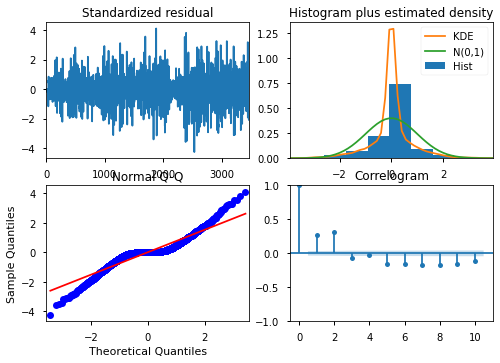

In [97]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Solar   No. Observations:                 3475
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood              -22248.968
Date:                                 Wed, 28 Jul 2021   AIC                          44507.936
Time:                                         11:30:09   BIC                          44538.701
Sample:                                     01-01-2021   HQIC                         44518.920
                                          - 05-25-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6054      0.008     74.011      0.000       0.589       0.621
ar.S.L24       0.9999   3.16e-05   3.16e+04      0.000       1.000       1.000
ma.S.L24      -0.6890      0.010    -71.674      0.000      -0.708      -0.670
ma.S.L48      -0.1006      0.010    -10.241      0.000      -0.120      -0.081
sigma2      2.045e+04    276.413     73.994      0.000    1.99e+04     2.1e+04
===================================================================================
Ljung-Box (L1) (Q):                 198.55   Jarque-Bera (JB):              2703.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


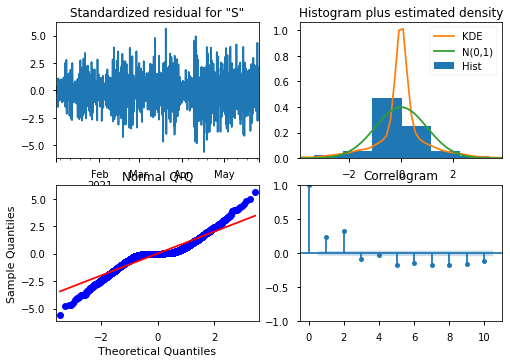

In [98]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=True).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [99]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI   Upper CI  Forecast
2021-05-25 19:00:00+00:00   -100.2350   460.3675  180.0663
2021-05-25 20:00:00+00:00   -524.0808   536.2366    6.0779
2021-05-25 21:00:00+00:00   -689.3124   701.4682    6.0779
2021-05-25 22:00:00+00:00   -822.2137   834.3696    6.0779
2021-05-25 23:00:00+00:00   -936.5601   948.7160    6.0779
...                               ...        ...       ...
2021-06-30 19:00:00+00:00 -69305.7293 69755.2686  224.7697
2021-06-30 20:00:00+00:00 -69587.0067 69692.2889   52.6411
2021-06-30 21:00:00+00:00 -69695.9848 69801.2671   52.6411
2021-06-30 22:00:00+00:00 -69804.7929 69910.0751   52.6411
2021-06-30 23:00:00+00:00 -69913.4318 70018.7140   52.6411

[869 rows x 3 columns]

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Datetime', ylabel='Value'>)

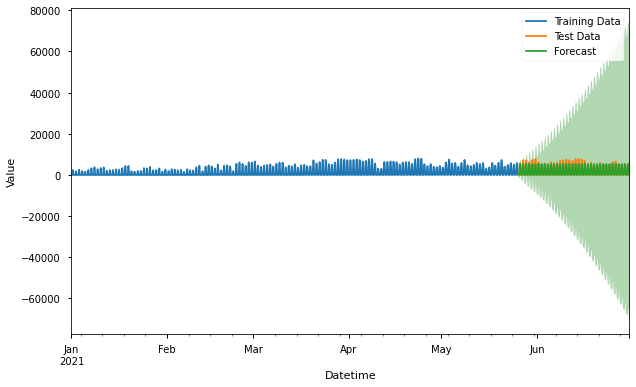

In [100]:
plot_train_test_forecast(train, test, forecast_df)

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Solar   No. Observations:                 4344
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood              -28349.755
Date:                                 Wed, 28 Jul 2021   AIC                          56709.509
Time:                                         11:30:53   BIC                          56741.333
Sample:                                     01-01-2021   HQIC                         56720.750
                                          - 06-30-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6308      0.008     79.246      0.000       0.615       0.646
ar.S.L24       1.0029      0.000   7378.003      0.000       1.003       1.003
ma.S.L24      -0.5667      0.023    -24.816      0.000      -0.612      -0.522
ma.S.L48      -0.4328      0.015    -29.014      0.000      -0.462      -0.404
sigma2      3.106e+04    619.568     50.133      0.000    2.98e+04    3.23e+04
===================================================================================
Ljung-Box (L1) (Q):                 247.38   Jarque-Bera (JB):              3043.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


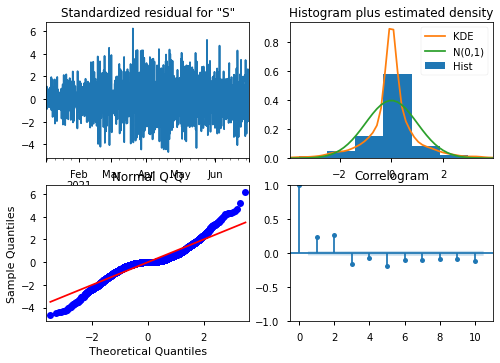

In [101]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(frace_solar_ts, order=model.order,seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [106]:
#Retrieve forecast for the next month
solar_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
solar_forecast_df

Lower CI   Upper CI  Forecast
2021-07-01 00:00:00+00:00   -338.6494   354.0113    7.6810
2021-07-01 01:00:00+00:00   -654.8541   670.1938    7.6698
2021-07-01 02:00:00+00:00   -862.9206   878.2547    7.6671
2021-07-01 03:00:00+00:00   -953.3440  1122.1391   84.3976
2021-07-01 04:00:00+00:00  -1017.4728  1345.4849  164.0061
...                               ...        ...       ...
2021-07-30 19:00:00+00:00 -23977.5159 24208.4663  115.4752
2021-07-30 20:00:00+00:00 -24099.6062 24128.1963   14.2951
2021-07-30 21:00:00+00:00 -24120.4969 24149.0896   14.2964
2021-07-30 22:00:00+00:00 -24142.3789 24168.9555   13.2883
2021-07-30 23:00:00+00:00 -24163.2348 24189.8115   13.2884

[720 rows x 3 columns]

Figure save as images/Solar_forecast.png


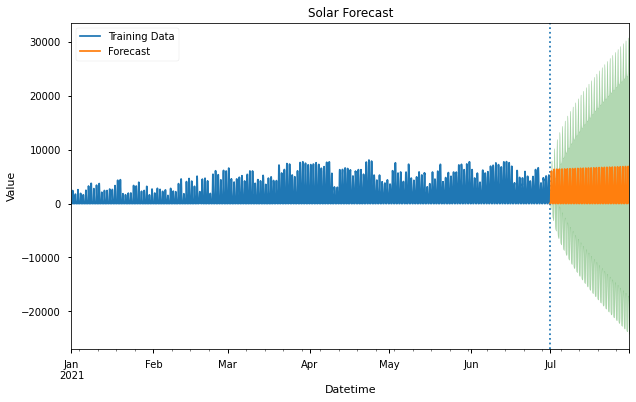

In [108]:
fig, ax = plot_time_series_forecast(frace_solar_ts, solar_forecast_df)

### Wind Modeling

<AxesSubplot:xlabel='Datetime'>

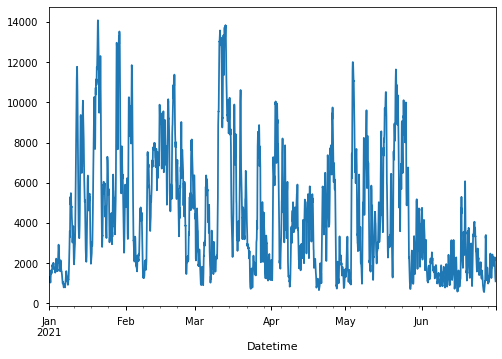

In [109]:
france_wind_ts = france_df['Wind Onshore']
france_wind_ts.plot()

In [110]:
train, test = train_test_split(france_wind_ts)

3475

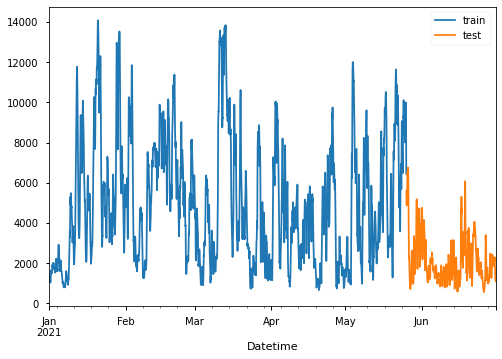

In [111]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -6.2944          26  ...   True         True

[1 rows x 6 columns]

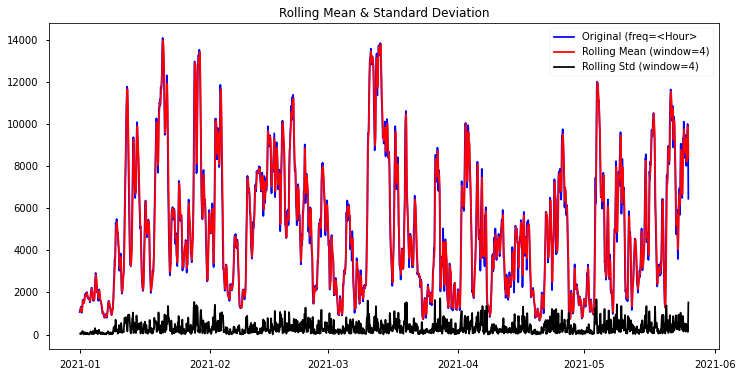

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -6.2944          26  ...   True         True

[1 rows x 6 columns]

In [112]:
#Check time series for stationarity
stationarity_check(train)

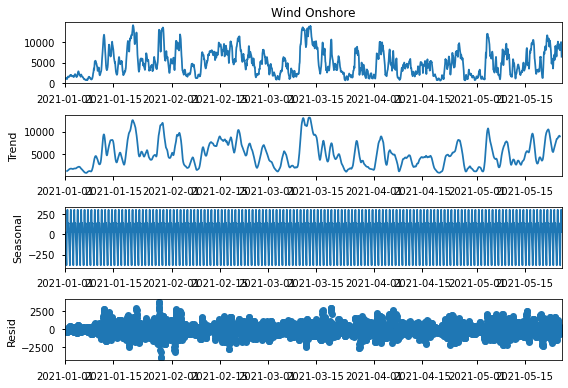

In [113]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

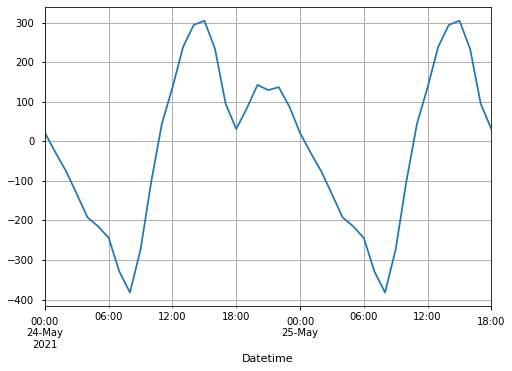

In [114]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=50890.893, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=48045.677, Time=3.73 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=48588.159, Time=4.31 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=50888.955, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=48280.585, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=47927.498, Time=17.43 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=36.05 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=50703.140, Time=15.70 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=47739.223, Time=20.99 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=47833.476, Time=4.95 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=51.96 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=10.92 sec
 ARIMA(3,1,0)(2,0,0)[24] intercept   : AIC=47714.297, Time=21.84 sec
 ARIMA(3,1,0)(1,0,0)[2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3475
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 24)   Log Likelihood              -23850.148
Date:                            Wed, 28 Jul 2021   AIC                          47712.296
Time:                                    11:44:20   BIC                          47749.214
Sample:                                         0   HQIC                         47725.477
                                           - 3475                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9379      0.013     73.749      0.000       0.913       0.963
ar.L2         -0.3152      0.017    -18.422      0.000      -0.349      -0.282
ar.L3          0.0882      0.013      6.672      0.000       0.062       0.114
ar.S.L24       0.1846      0.013     14.067      0.000       0.159       0.210
ar.S.L48       0.1631      0.015     11.190      0.000       0.135       0.192
sigma2      5.373e+04    893.778     60.119      0.000     5.2e+04    5.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               828.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


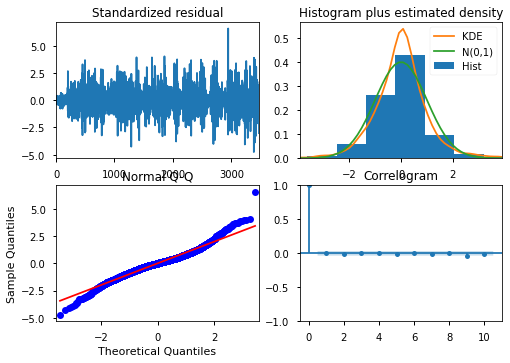

In [115]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Wind Onshore   No. Observations:                 3475
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 24)   Log Likelihood              -23522.459
Date:                            Wed, 28 Jul 2021   AIC                          47056.919
Time:                                    11:44:27   BIC                          47093.749
Sample:                                01-01-2021   HQIC                         47070.078
                                     - 05-25-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9383      0.013     72.712      0.000       0.913       0.964
ar.L2         -0.3153      0.017    -18.164      0.000      -0.349      -0.281
ar.L3          0.0884      0.013      6.590      0.000       0.062       0.115
ar.S.L24       0.1858      0.013     13.967      0.000       0.160       0.212
ar.S.L48       0.1652      0.015     11.182      0.000       0.136       0.194
sigma2       5.45e+04    920.612     59.197      0.000    5.27e+04    5.63e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               765.20
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


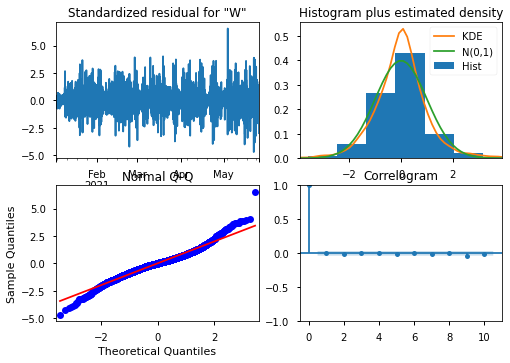

In [116]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [117]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI   Upper CI  Forecast
2021-05-25 19:00:00+00:00   4957.9970  5873.0955 5415.5463
2021-05-25 20:00:00+00:00   3746.4624  5742.3613 4744.4118
2021-05-25 21:00:00+00:00   2935.4258  5973.8146 4454.6202
2021-05-25 22:00:00+00:00   2362.6892  6352.7451 4357.7171
2021-05-25 23:00:00+00:00   1831.8868  6692.7531 4262.3200
...                               ...        ...       ...
2021-06-30 19:00:00+00:00 -69217.8427 71440.6788 1111.4180
2021-06-30 20:00:00+00:00 -69260.2537 71483.0898 1111.4180
2021-06-30 21:00:00+00:00 -69302.6392 71525.4753 1111.4180
2021-06-30 22:00:00+00:00 -69344.9992 71567.8353 1111.4180
2021-06-30 23:00:00+00:00 -69387.3338 71610.1698 1111.4180

[869 rows x 3 columns]

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Datetime', ylabel='Value'>)

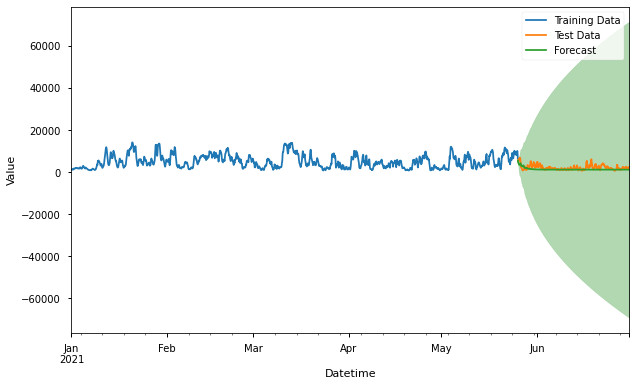

In [118]:
plot_train_test_forecast(train, test, forecast_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Wind Onshore   No. Observations:                 4344
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 24)   Log Likelihood              -29347.589
Date:                            Wed, 28 Jul 2021   AIC                          58707.179
Time:                                    11:44:35   BIC                          58745.366
Sample:                                01-01-2021   HQIC                         58720.667
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9098      0.009     97.561      0.000       0.891       0.928
ar.L2         -0.3016      0.013    -23.703      0.000      -0.327      -0.277
ar.L3          0.0874      0.010      8.463      0.000       0.067       0.108
ar.S.L24       0.1838      0.012     15.797      0.000       0.161       0.207
ar.S.L48       0.1581      0.013     12.173      0.000       0.133       0.184
sigma2       5.09e+04    665.472     76.483      0.000    4.96e+04    5.22e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2737.35
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


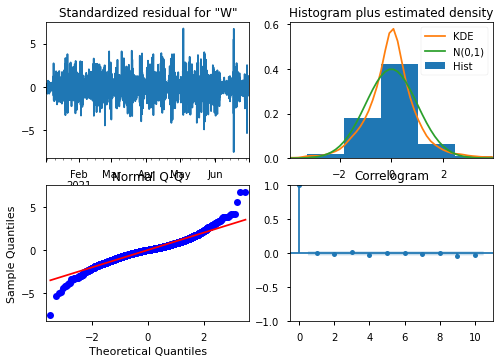

In [119]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(france_wind_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [120]:
#Retrieve forecast for the next month
wind_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
wind_forecast_df

Lower CI   Upper CI  Forecast
2021-07-01 00:00:00+00:00    598.1770  1482.5294 1040.3532
2021-07-01 01:00:00+00:00     61.9202  1968.3502 1015.1352
2021-07-01 02:00:00+00:00   -441.0511  2435.5313  997.2401
2021-07-01 03:00:00+00:00   -908.7499  2845.2264  968.2382
2021-07-01 04:00:00+00:00  -1320.1899  3232.9266  956.3683
...                               ...        ...       ...
2021-07-30 19:00:00+00:00 -57034.8826 58166.2869  565.7021
2021-07-30 20:00:00+00:00 -57077.1310 58208.5352  565.7021
2021-07-30 21:00:00+00:00 -57119.3484 58250.7527  565.7021
2021-07-30 22:00:00+00:00 -57161.5349 58292.9392  565.7021
2021-07-30 23:00:00+00:00 -57203.6907 58335.0950  565.7021

[720 rows x 3 columns]

Figure save as images/Wind Onshore_forecast.png


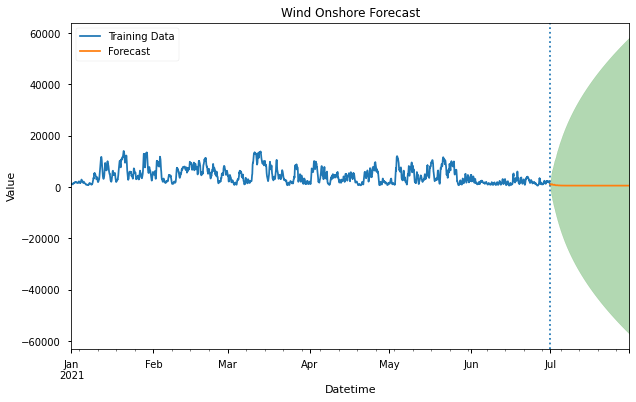

In [121]:
fig, ax = plot_time_series_forecast(france_wind_ts, wind_forecast_df)

### iNTERPRET

In [122]:
all_forecasts_df = pd.DataFrame()
all_forecasts_df['Solar Forecast'] = solar_forecast_df['Forecast']
all_forecasts_df['Onshore Wind Forecast'] = wind_forecast_df['Forecast']
all_forecasts_df.head()

Solar Forecast  Onshore Wind Forecast
2021-07-01 00:00:00+00:00          7.6810              1040.3532
2021-07-01 01:00:00+00:00          7.6698              1015.1352
2021-07-01 02:00:00+00:00          7.6671               997.2401
2021-07-01 03:00:00+00:00         84.3976               968.2382
2021-07-01 04:00:00+00:00        164.0061               956.3683

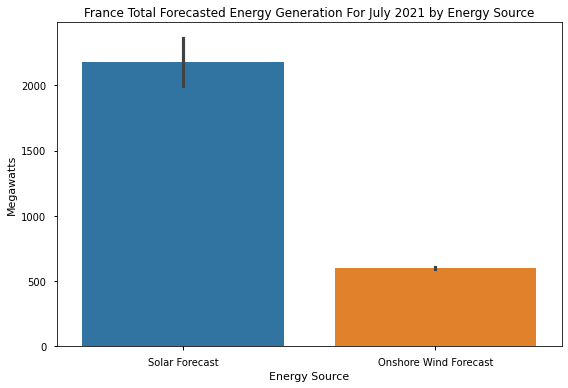

In [123]:
sns.barplot(data=all_forecasts_df, estimator=sum)
plt.title('France Total Forecasted Energy Generation For July 2021 by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Megawatts')
plt.tight_layout()
plt.savefig('images/France_forecast.png', dpi=300)

## Italy

### SCRUB/EXPLORE

In [124]:
italy_df = pd.read_csv("data/IT_df.csv")
italy_df.head()

Unnamed: 0  ...       Wind Onshore
0                        NaN  ...  Actual Aggregated
1  2021-01-01 01:00:00+01:00  ...             2801.0
2  2021-01-01 02:00:00+01:00  ...             2673.0
3  2021-01-01 03:00:00+01:00  ...             2671.0
4  2021-01-01 04:00:00+01:00  ...             2654.0

[5 rows x 16 columns]

In [125]:
italy_df.tail()

Unnamed: 0 Biomass  ... Waste Wind Onshore
4340  2021-06-30 21:00:00+02:00   681.0  ...  23.0       2621.0
4341  2021-06-30 22:00:00+02:00   679.0  ...  23.0       3299.0
4342  2021-06-30 23:00:00+02:00   689.0  ...  24.0       3359.0
4343  2021-07-01 00:00:00+02:00   702.0  ...  23.0       3539.0
4344  2021-07-01 01:00:00+02:00   690.0  ...  24.0       3842.0

[5 rows x 16 columns]

In [126]:
#Display DataFrame info

italy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Unnamed: 0                       4344 non-null   object
 1   Biomass                          4345 non-null   object
 2   Fossil Coal-derived gas          4345 non-null   object
 3   Fossil Gas                       4345 non-null   object
 4   Fossil Hard coal                 4345 non-null   object
 5   Fossil Hard coal.1               37 non-null     object
 6   Fossil Oil                       4345 non-null   object
 7   Geothermal                       4345 non-null   object
 8   Hydro Pumped Storage             4195 non-null   object
 9   Hydro Pumped Storage.1           2811 non-null   object
 10  Hydro Run-of-river and poundage  4345 non-null   object
 11  Hydro Water Reservoir            4345 non-null   object
 12  Other                            4

In [127]:
#Drop first row of DataFrame

italy_df = italy_df.drop(0)
italy_df.head()

Unnamed: 0 Biomass  ... Waste Wind Onshore
1  2021-01-01 01:00:00+01:00   706.0  ...  30.0       2801.0
2  2021-01-01 02:00:00+01:00   712.0  ...  31.0       2673.0
3  2021-01-01 03:00:00+01:00   710.0  ...  32.0       2671.0
4  2021-01-01 04:00:00+01:00   701.0  ...  33.0       2654.0
5  2021-01-01 05:00:00+01:00   700.0  ...  30.0       2521.0

[5 rows x 16 columns]

In [128]:
#Rename first column, will eventually become the index

italy_df.rename(columns = {"Unnamed: 0": "Datetime"}, inplace=True)
italy_df.head()

Datetime Biomass  ... Waste Wind Onshore
1  2021-01-01 01:00:00+01:00   706.0  ...  30.0       2801.0
2  2021-01-01 02:00:00+01:00   712.0  ...  31.0       2673.0
3  2021-01-01 03:00:00+01:00   710.0  ...  32.0       2671.0
4  2021-01-01 04:00:00+01:00   701.0  ...  33.0       2654.0
5  2021-01-01 05:00:00+01:00   700.0  ...  30.0       2521.0

[5 rows x 16 columns]

In [129]:
#Display dtypes, need to ensure 'Datetime' column is actually datetime dtype

italy_df.dtypes

Datetime                           object
Biomass                            object
Fossil Coal-derived gas            object
Fossil Gas                         object
Fossil Hard coal                   object
Fossil Hard coal.1                 object
Fossil Oil                         object
Geothermal                         object
Hydro Pumped Storage               object
Hydro Pumped Storage.1             object
Hydro Run-of-river and poundage    object
Hydro Water Reservoir              object
Other                              object
Solar                              object
Waste                              object
Wind Onshore                       object
dtype: object

In [130]:
#Change 'Datetime' dtype to datetime

italy_df['Datetime'] = pd.to_datetime(italy_df['Datetime'], utc=True)

italy_df['Datetime'].head()

1   2021-01-01 00:00:00+00:00
2   2021-01-01 01:00:00+00:00
3   2021-01-01 02:00:00+00:00
4   2021-01-01 03:00:00+00:00
5   2021-01-01 04:00:00+00:00
Name: Datetime, dtype: datetime64[ns, UTC]

In [131]:
#Change index of DataFrame to 'Datetime' column to create time series

italy_df = italy_df.set_index("Datetime")
italy_df.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-06-30 14:00:00+00:00', '2021-06-30 15:00:00+00:00',
               '2021-06-30 16:00:00+00:00', '2021-06-30 17:00:00+00:00',
               '2021-06-30 18:00:00+00:00', '2021-06-30 19:00:00+00:00',
               '2021-06-30 20:00:00+00:00', '2021-06-30 21:00:00+00:00',
               '2021-06-30 22:00:00+00:00', '2021-06-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=4344, freq=None)

In [132]:
#freq = 15T (15 minutes) so resample timeseries as hourly
italy_df = italy_df.resample('H').asfreq()
italy_df.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-06-30 14:00:00+00:00', '2021-06-30 15:00:00+00:00',
               '2021-06-30 16:00:00+00:00', '2021-06-30 17:00:00+00:00',
               '2021-06-30 18:00:00+00:00', '2021-06-30 19:00:00+00:00',
               '2021-06-30 20:00:00+00:00', '2021-06-30 21:00:00+00:00',
               '2021-06-30 22:00:00+00:00', '2021-06-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=4344, freq='H')

In [133]:
#Drop unnecessary columns

italy_df = italy_df[['Solar', 'Wind Onshore']]
italy_df.head()

Solar Wind Onshore
Datetime                                    
2021-01-01 00:00:00+00:00   0.0       2801.0
2021-01-01 01:00:00+00:00   0.0       2673.0
2021-01-01 02:00:00+00:00   0.0       2671.0
2021-01-01 03:00:00+00:00   0.0       2654.0
2021-01-01 04:00:00+00:00   0.0       2521.0

In [134]:
#Change dtypes from 'object' to 'float'

italy_df = italy_df.astype('float')

In [135]:
italy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344 entries, 2021-01-01 00:00:00+00:00 to 2021-06-30 23:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Solar         4344 non-null   float64
 1   Wind Onshore  4344 non-null   float64
dtypes: float64(2)
memory usage: 101.8 KB


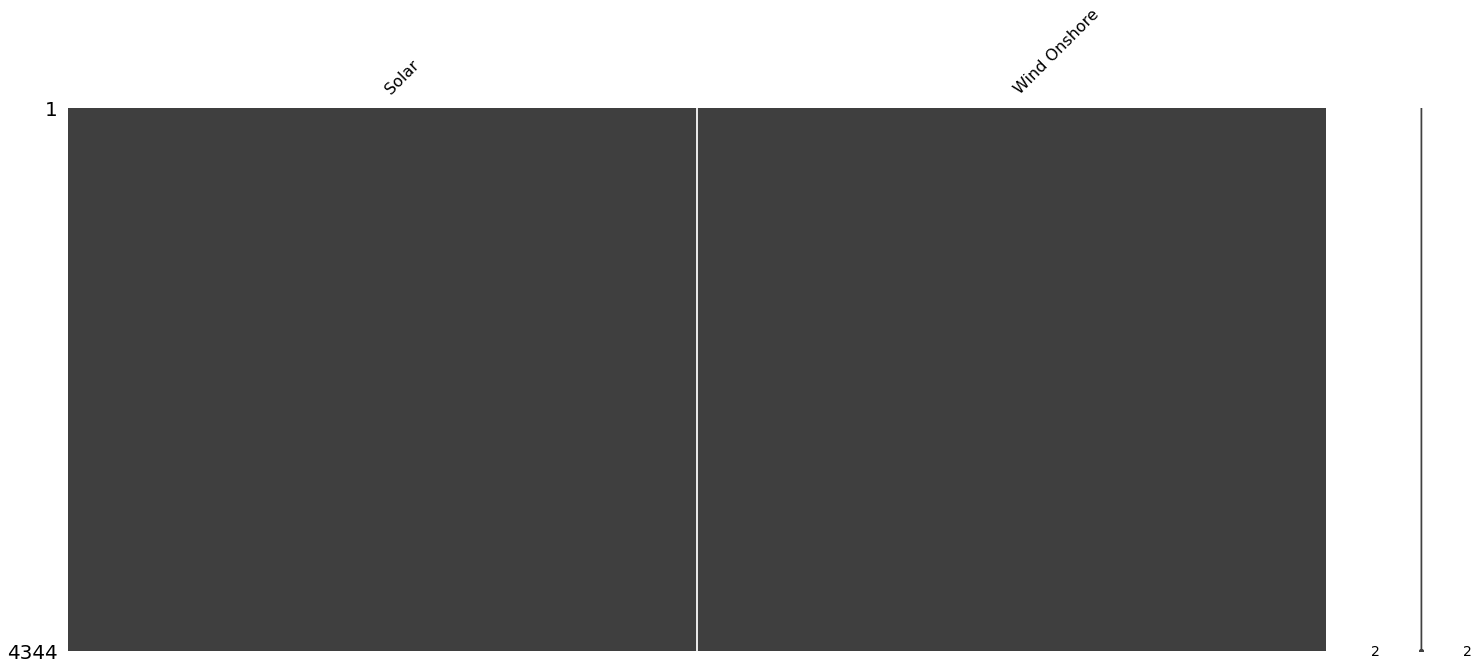

#null  %null
Solar             0 0.0000
Wind Onshore      0 0.0000

In [136]:
#Check for null values

check_nulls(italy_df)

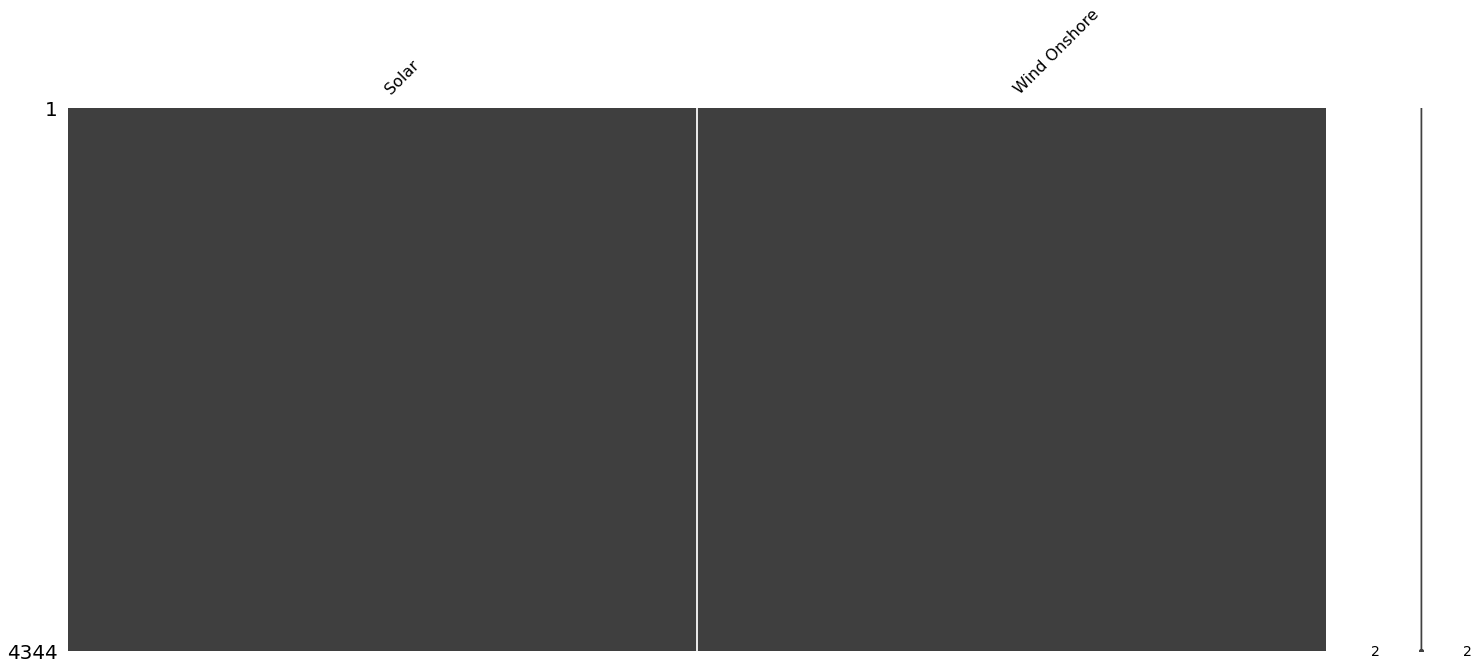

#null  %null
Solar             0 0.0000
Wind Onshore      0 0.0000

In [137]:
#Fill nulls
italy_df.fillna(method="ffill", inplace=True)
check_nulls(italy_df)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

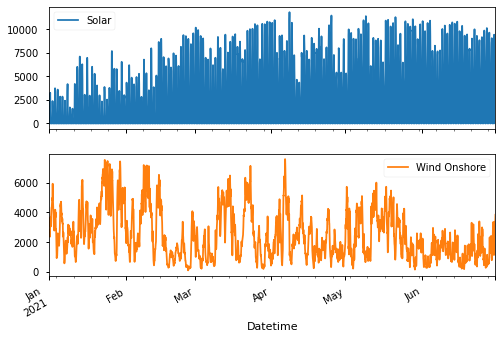

In [138]:
#Plot all time series
italy_df.plot(subplots=True)

From the plots above, we can see observe several things. Solar power has a very consistent cycle, producing high amounts of energy during daylight hours in spring, summer and fall. Wind has much more variable production, but is much more consistent through out the year, as the change in season does not affect it to the same degree as it does solar production.

### Solar Modeling

<AxesSubplot:xlabel='Datetime'>

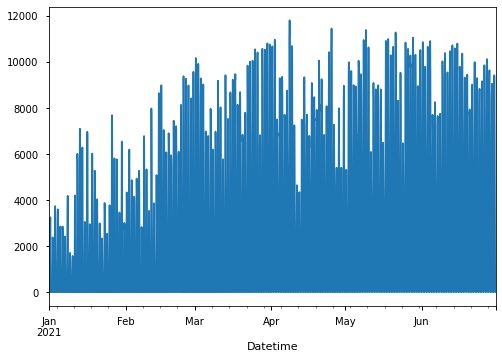

In [139]:
italy_solar_ts = italy_df['Solar']
italy_solar_ts.plot()

In [140]:
train, test = train_test_split(italy_solar_ts)

3475

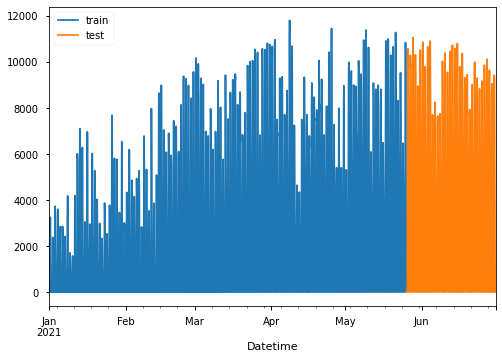

In [141]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -4.0661          30  ...   True         True

[1 rows x 6 columns]

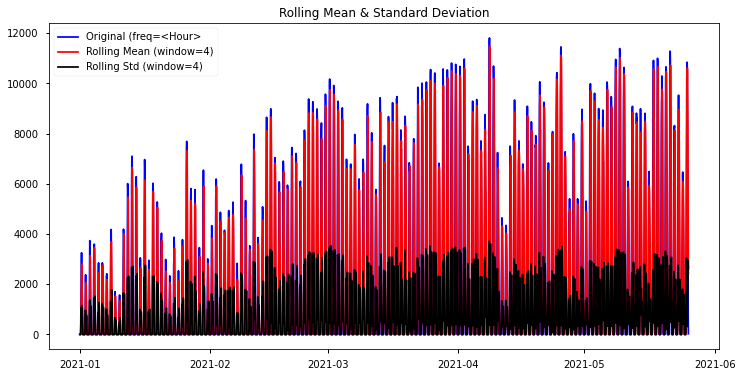

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -4.0661          30  ...   True         True

[1 rows x 6 columns]

In [142]:
#Check time series for stationarity
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results        -19.1411          25  ...   True         True

[1 rows x 6 columns]

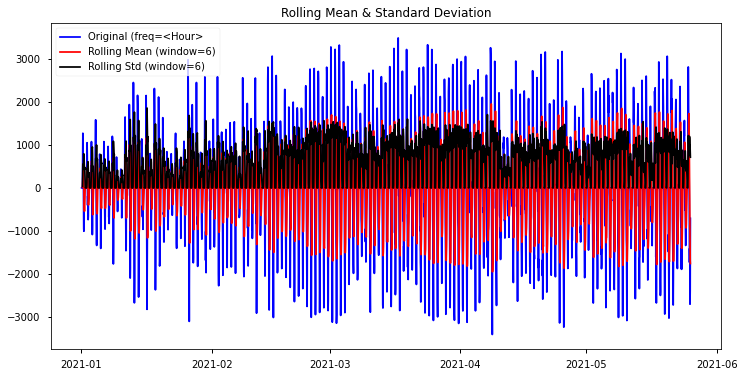

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results        -19.1411          25  ...   True         True

[1 rows x 6 columns]

In [143]:
#Check if differencing time series will result in stationarity
stationarity_check(train.diff().dropna(), window=6)

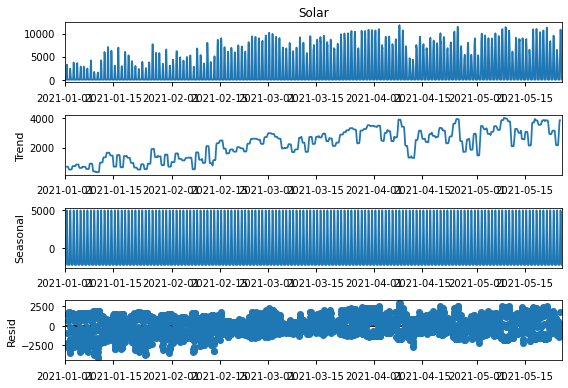

In [144]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

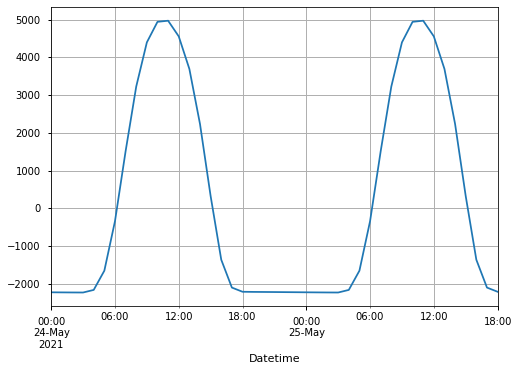

In [145]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

In [146]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True, error_action="ignore")
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=58110.851, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=7.53 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=53372.356, Time=4.69 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=58108.852, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=55042.514, Time=0.47 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=12.37 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=52356.572, Time=21.75 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=24.34 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=54117.728, Time=19.04 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=51587.310, Time=24.77 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=52274.684, Time=5.33 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=102.35 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=18.39 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=51774.696, Time=19.88 sec
 ARIMA(2,1,1)(0,0,2)[24] i

KeyboardInterrupt: 

In [ ]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [ ]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

In [ ]:
plot_train_test_forecast(train, test, forecast_df)

In [ ]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(italy_solar_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [ ]:
#Retrieve forecast for the next month
solar_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
solar_forecast_df

In [ ]:
fig, ax = plot_time_series_forecast(italy_solar_ts, solar_forecast_df)

### Wind Modeling

In [ ]:
italy_wind_ts = italy_df['Wind Onshore']
italy_wind_ts.plot()

In [ ]:
train, test = train_test_split(italy_wind_ts)

In [ ]:
plot_train_test_split(train, test);

In [ ]:
#Check time series for stationarity
stationarity_check(train)

In [ ]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

In [ ]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

In [ ]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

In [ ]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [ ]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

In [ ]:
plot_train_test_forecast(train, test, forecast_df)

In [ ]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(italy_wind_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [ ]:
#Retrieve forecast for the next month
wind_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
wind_forecast_df

In [ ]:
fig, ax = plot_time_series_forecast(italy_wind_ts, wind_forecast_df)

### iNTERPRET

In [ ]:
all_forecasts_df = pd.DataFrame()
all_forecasts_df['Solar Forecast'] = solar_forecast_df['Forecast']
all_forecasts_df['Onshore Wind Forecast'] = wind_forecast_df['Forecast']
all_forecasts_df.head()

In [ ]:
sns.barplot(data=all_forecasts_df, estimator=sum)
plt.title('Italy Total Forecasted Energy Generation For July 2021 by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Megawatts')
plt.tight_layout()
plt.savefig('images/Italy_forecast.png', dpi=300)

## Spain

### SCRUB/EXPLORE

In [ ]:
spain_df = pd.read_csv("data/ES_df.csv")
spain_df.head()

In [ ]:
spain_df.tail()

In [ ]:
#Display DataFrame info

spain_df.info()

In [ ]:
#Drop first row of DataFrame

spain_df = spain_df.drop(0)
spain_df.head()

In [ ]:
#Rename first column, will eventually become the index

spain_df.rename(columns = {"Unnamed: 0": "Datetime"}, inplace=True)
spain_df.head()

In [ ]:
#Display dtypes, need to ensure 'Datetime' column is actually datetime dtype

spain_df.dtypes

In [ ]:
#Change 'Datetime' dtype to datetime

spain_df['Datetime'] = pd.to_datetime(spain_df['Datetime'], utc=True)

spain_df['Datetime'].head()

In [ ]:
#Change index of DataFrame to 'Datetime' column to create time series

spain_df = spain_df.set_index("Datetime")
spain_df.index

In [ ]:
#freq = 15T (15 minutes) so resample timeseries as hourly
spain_df = spain_df.resample('H').asfreq()
spain_df.index

In [ ]:
#Drop unnecessary columns

spain_df = spain_df[['Solar', 'Wind Onshore']]
spain_df.head()

In [ ]:
#Change dtypes from 'object' to 'float'

spain_df = spain_df.astype('float')

In [ ]:
spain_df.info()

In [ ]:
#Check for null values

check_nulls(spain_df)

In [ ]:
#Fill nulls
spain_df.fillna(method="ffill", inplace=True)
check_nulls(spain_df)

In [ ]:
#Plot all time series
spain_df.plot(subplots=True)

From the plots above, we can see observe several things. Solar power has a very consistent cycle, producing high amounts of energy during daylight hours in spring, summer and fall. Wind has much more variable production, but is much more consistent through out the year, as the change in season does not affect it to the same degree as it does solar production.

### Solar Modeling

In [ ]:
spain_solar_ts = spain_df['Solar']
spain_solar_ts.plot()

In [ ]:
train, test = train_test_split(spain_solar_ts)

In [ ]:
plot_train_test_split(train, test);

In [ ]:
#Check time series for stationarity
stationarity_check(train)

In [ ]:
#Check if differencing time series will result in stationarity
stationarity_check(train.diff().dropna(), window=6)

In [ ]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

In [ ]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

In [ ]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True, error_action="ignore")
display(model.summary())
model.plot_diagnostics();

In [ ]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [ ]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

In [ ]:
plot_train_test_forecast(train, test, forecast_df)

In [ ]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(spain_solar_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [ ]:
#Retrieve forecast for the next month
solar_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
solar_forecast_df

In [ ]:
fig, ax = plot_time_series_forecast(spain_solar_ts, solar_forecast_df)

### Onshore Wind Modeling

In [ ]:
spain_wind_ts = spain_df['Wind Onshore']
spain_wind_ts.plot()

In [ ]:
train, test = train_test_split(spain_wind_ts)

In [ ]:
plot_train_test_split(train, test);

In [ ]:
#Check time series for stationarity
stationarity_check(train)

In [ ]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

In [ ]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

In [ ]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

In [ ]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [ ]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

In [ ]:
plot_train_test_forecast(train, test, forecast_df)

In [ ]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(spain_wind_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [ ]:
#Retrieve forecast for the next month
wind_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
wind_forecast_df

In [ ]:
fig, ax = plot_time_series_forecast(spain_wind_ts, wind_forecast_df)

### iNTERPRET

In [ ]:
all_forecasts_df = pd.DataFrame()
all_forecasts_df['Solar Forecast'] = solar_forecast_df['Forecast']
all_forecasts_df['Onshore Wind Forecast'] = wind_forecast_df['Forecast']
all_forecasts_df.head()

In [ ]:
sns.barplot(data=all_forecasts_df, estimator=sum)
plt.title('Spain Total Forecasted Energy Generation For July 2021 by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Megawatts')
plt.tight_layout()
plt.savefig('images/Spain_forecast.png', dpi=300)

## Netherlands

### SCRUB/EXPLORE

In [ ]:
netherlands_df = pd.read_csv("data/NL_df.csv")
netherlands_df.head()

In [ ]:
netherlands_df.tail()

In [ ]:
#Display DataFrame info

netherlands_df.info()

In [ ]:
#Drop first row of DataFrame

netherlands_df = netherlands_df.drop(0)
netherlands_df.head()

In [ ]:
#Rename first column, will eventually become the index

netherlands_df.rename(columns = {"Unnamed: 0": "Datetime"}, inplace=True)
netherlands_df.head()

In [ ]:
#Display dtypes, need to ensure 'Datetime' column is actually datetime dtype

netherlands_df.dtypes

In [ ]:
#Change 'Datetime' dtype to datetime

netherlands_df['Datetime'] = pd.to_datetime(netherlands_df['Datetime'], utc=True)

netherlands_df['Datetime'].head()

In [ ]:
#Change index of DataFrame to 'Datetime' column to create time series

netherlands_df = netherlands_df.set_index("Datetime")
netherlands_df.index

In [ ]:
#freq = 15T (15 minutes) so resample timeseries as hourly
netherlands_df = netherlands_df.resample('H').asfreq()
netherlands_df.index

In [ ]:
#Drop unnecessary columns

netherlands_df = netherlands_df[['Solar', 'Wind Offshore', 'Wind Onshore']]
netherlands_df.head()

In [ ]:
#Change dtypes from 'object' to 'float'

netherlands_df = netherlands_df.astype('float')

In [ ]:
netherlands_df.info()

In [ ]:
#Check for null values

check_nulls(netherlands_df)

In [ ]:
#Fill nulls
netherlands_df.fillna(method="ffill", inplace=True)
check_nulls(netherlands_df)

In [ ]:
#Plot all time series
netherlands_df.plot(subplots=True)

From the plots above, we can see observe several things. Solar power has a very consistent cycle, producing high amounts of energy during daylight hours in spring, summer and fall. Wind has much more variable production, but is much more consistent through out the year, as the change in season does not affect it to the same degree as it does solar production.

### Solar Modeling

In [ ]:
netherlands_solar_ts = netherlands_df['Solar']
netherlands_solar_ts.plot()

In [ ]:
train, test = train_test_split(netherlands_solar_ts)

In [ ]:
plot_train_test_split(train, test);

In [ ]:
#Check time series for stationarity
stationarity_check(train)

In [ ]:
#Check if differencing time series will result in stationarity
stationarity_check(train.diff().dropna(), window=6)

In [ ]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

In [ ]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

In [ ]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

In [ ]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [ ]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

In [ ]:
plot_train_test_forecast(train, test, forecast_df)

In [ ]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(netherlands_solar_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [ ]:
#Retrieve forecast for the next month
solar_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
solar_forecast_df

In [ ]:
fig, ax = plot_time_series_forecast(netherlands_solar_ts, solar_forecast_df)

### Onshore Wind Modeling

In [ ]:
netherlands_onshore_wind_ts = netherlands_df['Wind Onshore']
netherlands_onshore_wind_ts.plot()

In [ ]:
train, test = train_test_split(netherlands_onshore_wind_ts)

In [ ]:
plot_train_test_split(train, test);

In [ ]:
#Check time series for stationarity
stationarity_check(train)

In [ ]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

In [ ]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

In [ ]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

In [ ]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [ ]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

In [ ]:
plot_train_test_forecast(train, test, forecast_df)

In [ ]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(netherlands_onshore_wind_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [ ]:
#Retrieve forecast for the next month
onshore_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
onshore_forecast_df

In [ ]:
fig, ax = plot_time_series_forecast(netherlands_onshore_wind_ts, onshore_forecast_df)

### Offshore Wind Modeling

In [ ]:
netherlands_offshore_wind_ts = netherlands_df['Wind Offshore']
netherlands_offshore_wind_ts.plot()

In [ ]:
train, test = train_test_split(netherlands_offshore_wind_ts)

In [ ]:
plot_train_test_split(train, test);

In [ ]:
#Check time series for stationarity
stationarity_check(train)

In [ ]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

In [ ]:
#Zoom in on shorter time period
decompose.seasonal.loc['2021-05-24':].plot()
plt.grid(which='both')

In [ ]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=24, trace=True)
display(model.summary())
model.plot_diagnostics();

In [ ]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [ ]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

In [ ]:
plot_train_test_forecast(train, test, forecast_df)

In [ ]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(netherlands_offshore_wind_ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=False).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [ ]:
#Retrieve forecast for the next month
offshore_forecast_df = retrieve_forecast(sarimax_model_full, steps=720)
offshore_forecast_df

In [ ]:
fig, ax = plot_time_series_forecast(netherlands_offshore_wind_ts, offshore_forecast_df)

### iNTERPRET

In [ ]:
all_forecasts_df = pd.DataFrame()
all_forecasts_df['Solar Forecast'] = solar_forecast_df['Forecast']
all_forecasts_df['Onshore Wind Forecast'] = onshore_forecast_df['Forecast']
all_forecasts_df['Offshore Wind Forecast'] = offshore_forecast_df['Forecast']
all_forecasts_df.head()

In [ ]:
sns.barplot(data=all_forecasts_df, estimator=sum)
plt.title('Netherlands Total Forecasted Energy Generation For July 2021 by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Megawatts')
plt.tight_layout()
plt.savefig('images/Netherlands_forecast.png', dpi=300)

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***